In [1]:
## SETUP
# conda create -n stats python=2 pip numpy matplotlib pandas scipy scikit-learn seaborn jinja2 ipykernel
# source activate stats
# pip install bootstrapped

#%matplotlib notebook
%matplotlib inline
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.sparse import coo_matrix
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

from math import sqrt
import shutil
import json
import os, sys, re
display(HTML("<style>.container { width:100% !important; }</style>"))
# display multiple dataframes next to each other
#CSS = """
#.output {
#    flex-direction: row;
#}
#"""
#HTML('<style>{}</style>'.format(CSS))

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [5]:
# load data from server
LOAD_DATA = False
TEST_RED = False
TEST_BASE_MODELS = False
SAVE_DF_DROPPED = False
server_adress = 'gpu' # defined in ~/.ssh/config

#task = 'RELATEDNESS/SICK'
#task = 'ENTAILMENT/SICK'
#task = 'SENTIMENT/IMDB'
task = 'RE/SEMEVAL2010T8'
#task = 'ALL'
print('task: %s' % task)

path_server = '~/train/FINAL/'
path = '/mnt/DATA/ML/experiments/FINAL/'
#path = '/mnt/DATA/ML/experiments/SEARCH/'

parameters_final = ['model', 'linking', 'structure']
parameters_dev = ['model', 'linking', 'structure', 'st', 'fc', 'nfv', 'vvr', 'vvz', 'lr', 'kp', 'd']
dev = not '/FINAL' in path 
#best_only = True
best_only = False
print('dev=%s' % dev)
task_settings = {'ENTAILMENT/SICK': 
                     {'file': 'entailment.tsv',
                      'metrics': ['test_accuracy_t50', 'time_s'],
                      'metrics_dev': ['dev_best_accuracy_t50', 'time_s'],
                      'parameters': parameters_dev if dev else parameters_final,
                      'data': {'DIRECT': 'SICK_RDF/corenlp_noner_recemb_mc2', 'EDGES': 'SICK_RDF/corenlp_noner_recemb_edges_mc2'},
                     },
                  'RELATEDNESS/SICK': 
                     {'file': 'relatedness.tsv',
                      'metrics': ['test_pearson_r', 'test_mse', 'abs_error', 'time_s'],
                      'metrics_dev': ['dev_best_pearson_r', 'dev_best_mse', 'time_s'],
                      'parameters': parameters_dev if dev else parameters_final,
                      'data': {'DIRECT': 'SICK_RDF/corenlp_noner_recemb_mc2', 'EDGES': 'SICK_RDF/corenlp_noner_recemb_edges_mc2'},
                     },
                  'SENTIMENT/IMDB': 
                     {'file': 'sentiment.tsv',
                      'metrics': ['test_accuracy_t50', 'time_s'],
                      'metrics_dev': ['dev_best_accuracy_t50', 'time_s'],
                      'parameters': parameters_dev if dev else parameters_final,
                      'filters_in': [{'sl': ['500']}, {'dpth': ['50']}],
                      'data': {'DIRECT': 'IMDB_RDF/corenlp_noner_recemb_mc20', 'EDGES': 'IMDB_RDF/corenlp_noner_recemb_edges_mc20'},
                     },
                  'RE/SEMEVAL2010T8':
                   {'file': 're_semeval2010t8.tsv',
                      'metrics': ['f1_macro', 'f1_wo_norelation_micro', 'test_f1_t33', 'time_s'],
                      #'metrics': ['test_f1_t33', 'time_s'],
                      'metrics_dev': ['dev_best_f1_t33', 'time_s'],
                      'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                      'parameters': parameters_dev if dev else parameters_final,
                      #'filters_out': [{'dir_clean': ['RECNN_FULLTREE']}, {'m': ['LM:SUM-GRU', 'LM:MAX-GRU']}],
                    'data': {'DIRECT': 'SEMEVAL2010T8_RDF/corenlp_recemb_mc2', 'EDGES': 'SEMEVAL2010T8_RDF/corenlp_recemb_edges_mc2_FIXED','SPAN': 'SEMEVAL2010T8_RDF/corenlp_recemb_span_mc2'},
                     },
                 
                 'ALL':
                   {'file': 'ALL',
                      'metrics': ['metric_main', 'time_s'],
                      #'metrics': ['test_f1_t33', 'time_s'],
                      'metrics_dev': None,
                      #'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                      'parameters': parameters_dev if dev else parameters_final,
                      #'filters_out': [{'dir_clean': ['RECNN_FULLTREE']}, {'m': ['LM:SUM-GRU', 'LM:MAX-GRU']}],
                    'data': None,# {'DIRECT': 'SEMEVAL2010T8_RDF/corenlp_recemb_mc2', 'EDGES': 'SEMEVAL2010T8_RDF/corenlp_recemb_edges_mc2_FIXED','SPAN': 'SEMEVAL2010T8_RDF/corenlp_recemb_span_mc2'},
                     },
                  #'RE/tacred':
                  # {'path': path + 're_tacred.tsv',
                  #    'metrics': ['test_f1_t33', 'time_s'],
                  #    'metrics_dev': ['dev_best_f1_t33', 'f1_wo_norelation_macro', 'f1_wo_norelation_micro', 'time_s'],
                  #    'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1', 'test_f1_t33': 'test_recall@1'},
                  #    'parameters': parameters_dev if dev else parameters_final,
                  #   },
                 }

#settings = {
    #'path': '/mnt/DATA/ML/experiments/FINAL/relatedness.tsv',
    #'path': '/mnt/DATA/ML/experiments/SEARCH/RE/SEMEVAL2010T8/re_semeval_search.tsv',
    #'path': '/mnt/DATA/ML/experiments/FINAL/entailment.tsv',
    #'metrics_task': ['pearson_r'],
    #'metrics': ['dev_best_f1_t33', 'time_s'],
    
    #'metrics_alternative': {'dev_best_f1_t33': 'dev_best_recall@1'},
    #'metric_dev': 'dev_best_pearson_r',
    #'parameters': ['data', 'te', ''], # entries from run_desc
    #'parameters': ['m', 'st', 'fc', 'dir', 'l', 'nfv', 'vvr', 'vvz']
    #'parameters':
    #'select': {'m': ['GRU', 'SUM-GRU']}
#}

task_setting = task_settings[task]
#path = '/mnt/DATA/ML/experiments/FINAL/relatedness.tsv'
#metrics_task = ['pearson_r']
fn = task_setting['file']
fn_path = os.path.join(path, fn)
print('fn_path: %s' % fn_path)

task: RE/SEMEVAL2010T8
dev=False
fn_path: /mnt/DATA/ML/experiments/FINAL/re_semeval2010t8.tsv


In [6]:
# get result files from server
if LOAD_DATA and task != 'ALL':
    #assert path.endswith('/'), 'path has to end with "/" to copy files'
    if not path.endswith('/'):
        path += '/'
    print('copy file(s) to: %s' % path)
    # copy all files
    #!scp {server_adress}:'{path_server}*.tsv' {path}
    # copy only task file
    !scp {server_adress}:{path_server}{fn} {path}
    print('DONE')

In [7]:

#metrics_task = settings['metrics_task']
if dev:
    metrics = task_setting['metrics_dev']
else:
    metrics = task_setting['metrics']
metric_main = metrics[0]
print('use metrics: %s' % metrics)
print('metric_main: %s' % metric_main)
metrics_alternative = task_setting.get('metrics_alternative', {})
parameters = task_setting['parameters']
print('use parameters: %s' % parameters)
select = task_setting.get('select', {})
metrics_inverted = ['time_s', 'steps_train']

filters_in = task_setting.get('filters_in', None)
filters_out = task_setting.get('filters_out', None)

if task != 'ALL':
    df_loaded = pd.read_csv(fn_path, sep='\t')


    #df_loaded.apply(lambda row: row['dev_best_recall@1'] or row['dev_best_f1_t33'],axis=1)
    for m_alt in metrics_alternative: 
        df_loaded[m_alt].fillna(df_loaded[metrics_alternative[m_alt]], inplace=True)

    def get_current_values(df):
        return {p: list(set(df[p])) for p in parameters}

    df_loaded['dir_clean'] = df_loaded['dir'].replace('\d+', '', regex=True)
    if task == 'RE/SEMEVAL2018T8':
        print('rename dir_clean entries: RECNN -> RECNN_LCA, RECNN_FULLTREE -> RECNN')
        indices_recnn =  df_loaded[df_loaded['dir_clean'] == 'RECNN']
        indices_recnn_fulltree =  df_loaded[df_loaded['dir_clean'] == 'RECNN_FULLTREE']
        df_loaded.loc[df_loaded['dir_clean'] == 'RECNN', 'dir_clean'] = 'RECNN_LCA' #['RECNN_LCA'] * np.count_nonzero(indices_recnn)
        df_loaded.loc[df_loaded['dir_clean'] == 'RECNN_FULLTREE', 'dir_clean'] = 'RECNN'
        #df_loaded['dir_clean'][indicesindices_recnn_fulltree_recnn] = 'RECNN'

    # exclude: dir==RECNN_FULLTREE
    #df_loaded = df_loaded[df_loaded['dir'] != 'RECNN_FULLTREE']
    #df_loaded.drop(df_loaded[df_loaded['dir'] == 'RECNN_FULLTREE'].index, axis=0, inplace=True)
    #df_loaded.reset_index(drop=True, inplace=True)
else:
    df_loaded_list = []
    for fn in os.listdir(fn_path):
        fn_full = os.path.join(fn_path, fn)
        print('load: %s' % fn_full)
        df_loaded_temp = pd.read_pickle(fn_full)
        df_loaded_temp['task'] = fn.replace('-', '/')
        # defaults (for task != RE/SEMEVAL2018T8)
        if 'ct' not in df_loaded_temp:
            df_loaded_temp['ct'] = 'TREE'
        if 'dir_clean' not in df_loaded_temp:
            df_loaded_temp['dir_clean'] = 'RECNN'
        if 'd' not in df_loaded_temp:
            df_loaded_temp['d'] = 'F'
        if 'n' not in df_loaded_temp:
            df_loaded_temp['n'] = '10000'
        df_loaded_list.append(df_loaded_temp)
    df_loaded = pd.concat(df_loaded_list, axis=0).fillna('-')
    run_desc_cols = ['n']
print('loaded %i records' % len(df_loaded))
    #set(df_loaded['dir_clean'])


use metrics: ['f1_macro', 'f1_wo_norelation_micro', 'test_f1_t33', 'time_s']
metric_main: f1_macro
use parameters: ['model', 'linking', 'structure']
loaded 2180 records


In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_loaded[-5:]
#df_loaded[['tree_embedder', metrics[0]]].groupby('tree_embedder').count()
#df_loaded[df_loaded['tree_embedder'] == 'HTUBatchedHead_reduceMAX_mapGRU'][:10]

,add_heads,bidirectional,dev_best_accuracy_t33,dev_best_accuracy_t50,dev_best_accuracy_t66,dev_best_f1_t33,dev_best_f1_t50,dev_best_f1_t66,dev_best_precision_t33,dev_best_precision_t50,dev_best_precision_t66,dev_best_recall@1,dev_best_recall@2,dev_best_recall@3,dev_best_recall@5,dev_best_recall_t33,dev_best_recall_t50,dev_best_recall_t66,dev_file_indices,dir,f1_macro,f1_wo_norelation_micro,keep_prob,leaf_fc_size,nbr_trees,path,run_desc,run_description,steps_train,test_accuracy_t33,test_accuracy_t50,test_accuracy_t66,test_f1_t33,test_f1_t50,test_f1_t66,test_precision_t33,test_precision_t50,test_precision_t66,test_recall@1,test_recall@2,test_recall@3,test_recall@5,test_recall_t33,test_recall_t50,test_recall_t66,time_s,tree_embedder,dir_clean
2175,NaN,NaN,0.958823,0.962740,0.962970,0.617080,0.595136,0.549459,0.604317,0.695071,0.763920,NaN,NaN,NaN,NaN,0.630394,0.520325,0.429018,"8,9",BOW,0.6697,0.6822,0.9,250.0,NaN,RE/SEMEVAL2010T8/DIRECT/BOW,aEDG-ARGS_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_c...,aEDG-ARGS_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_c...,448,0.960647,0.963943,0.964214,0.634366,0.614747,0.571296,0.620726,0.702319,0.773099,NaN,NaN,NaN,NaN,0.648619,0.546593,0.453039,87.546848,FLAT_MAX,BOW
2176,NaN,NaN,0.959350,0.963497,0.963596,0.621977,0.603220,0.554392,0.609113,0.704850,0.779162,NaN,NaN,NaN,NaN,0.635397,0.527204,0.430269,"8,9",BOW,0.6587,0.6722,0.9,250.0,NaN,RE/SEMEVAL2010T8/DIRECT/BOW,aEDG-ARGS_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_c...,aEDG-ARGS_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_c...,448,0.960221,0.965048,0.964466,0.630670,0.624922,0.567994,0.616684,0.717973,0.788613,NaN,NaN,NaN,NaN,0.645304,0.553223,0.443831,86.928456,FLAT_MAX,BOW
2177,NaN,NaN,0.958428,0.961160,0.962312,0.621289,0.617380,0.606123,0.596774,0.641077,0.673547,NaN,NaN,NaN,NaN,0.647905,0.595372,0.550969,"8,9",BOW,0.6666,0.6784,0.9,250.0,NaN,RE/SEMEVAL2010T8/DIRECT/BOW,aEDG-ARGS_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_c...,aEDG-ARGS_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_c...,1344,0.959349,0.962218,0.963109,0.630093,0.629538,0.615322,0.604604,0.650432,0.681900,NaN,NaN,NaN,NaN,0.657827,0.609945,0.560589,136.796558,FLAT_MAX,BOW
2178,NaN,NaN,0.959481,0.963069,0.964978,0.630219,0.626000,0.615051,0.606358,0.670236,0.729614,NaN,NaN,NaN,NaN,0.656035,0.587242,0.531582,"8,9",BOW,0.6698,0.6807,0.9,250.0,NaN,RE/SEMEVAL2010T8/DIRECT/BOW,aEDG-ARGS_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_c...,aEDG-ARGS_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_c...,768,0.961268,0.964176,0.965339,0.646246,0.639485,0.622785,0.622230,0.679801,0.728889,NaN,NaN,NaN,NaN,0.672191,0.603683,0.543646,103.712325,FLAT_MAX,BOW
2179,NaN,NaN,0.959251,0.961489,0.962542,0.628897,0.615132,0.595881,0.603915,0.648855,0.689400,NaN,NaN,NaN,NaN,0.656035,0.584740,0.524703,"8,9",BOW,0.6605,0.6714,0.9,250.0,NaN,RE/SEMEVAL2010T8/DIRECT/BOW,aEDG-ARGS_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_c...,aEDG-ARGS_avfF_bs100_dF_b_clp5.0_cmAGGREGATE_c...,960,0.959426,0.962334,0.963904,0.629623,0.625410,0.616399,0.605926,0.656149,0.699392,NaN,NaN,NaN,NaN,0.655249,0.597422,0.551013,114.236401,FLAT_MAX,BOW


In [9]:
COLUMN_RUN = 'run'
COLUMN_RUN_DESC_COLS = 'run_desc_cols'
COLUMN_DFIDX = 'dfidx'
COLUMN_RUN_DESC = 'run_description'
COLUMN_RUN_DESC_NEW = 'run_desc_new'

#map_value_short = {'CORENLPNONERRECEMBEDGESMC2': 'E', 
#             'CORENLPNONERRECEMBMC2': 'D',
#             #'HTUREDUCEMAXMAPGRU': 'MAX-GRU',
#             #'HTUREDUCESUMMAPGRU': 'SUM-GRU',
#             #'FLATGRU': 'GRU',
#             #'FLATSUM': 'SUM',
#             #'FLATMAX': 'MAX',
#            }
metrics_description = {'f1_macro': 'F1 macro', 'f1_wo_norelation_micro': 'F1 micro w/o no_relation', 'test_f1_t33': 'F1 micro', 'time_s': 'Time in s', 'test_accuracy_t50': 'Accuracy', 'test_pearson_r': "Pearson's r", 'test_mse': 'MSE'}
map_value_long = {'E': 'edges', 'D': 'direct'}
map_param_short = {'data': 'l', 'te': 'm', 'linking': 'l', 'model': 'm', 'structure': 'str'}
map_param_long = {'l': 'linking', 'm': 'model', 'str': 'structure', 'red': 'f_reduce', 'map': 'f_map'}
map_task_long = {'RTE': 'Rogognizing Textual Entailment', 'RP': 'Relatedness Prediction', 'SA': 'Sentiment Analysis', 'RE/semeval': 'Relation Extraction (SemEval)', 'RE/tacred': 'Relation Extraction (TacRED)'}
map_task_short = {'RE': 'RE', 'ENTAILMENT': 'RTE', 'RELATEDNESS': 'RP', 'SENTIMENT': 'SA'}
map_structure_to_order_awareness = {'BOW': 'NONE', 'RNN': 'FULL', 'RECNN': 'PARTLY'}
parameters = [map_param_short.get(p, p) for p in parameters]


def filter_iter(df, filters):
    for filter_dicts in filters:
        if isinstance(filter_dicts, dict):
            filter_dict_in = filter_dicts
            filter_dict_out = {}  
        else:
            filter_dict_in, filter_dict_out = filter_dicts
      
        filter_in = np.ones(len(df), dtype=bool)
        filter_out = np.zeros(len(df), dtype=bool)
        for k in filter_dict_in:
            filter_in = filter_in & df[k].isin(filter_dict_in[k])
        for k in filter_dict_out:
            filter_out = filter_out | df[k].isin(filter_dict_out[k])
        #filter_all = filter_all | (filter_in & filter_out)
        yield df[filter_in & ~filter_out], filter_dict_in, filter_dict_out

def format_description(v, vtype=None):
    if isinstance(v, list):
        return ', '.join([format_description(_v, vtype=vtype) for _v in v])
    
    #if vtype == 'm':
    if vtype == 'metric':
        return metrics_description[v]
    if vtype == 'parameter':
        return map_param_long[v]
    if vtype == 'task':
        return map_task_short[v.split('/')[0].upper()]
    if vtype == 'pass':
        return v
    if vtype == 'structure_to_order_awareness':
        return map_structure_to_order_awareness[v]
    raise AssertionError('unkown vtype=%s' % vtype)

def as_suffixes(v, suffixes):
    found = []
    for suffix in suffixes:
        if suffix in v:
            found.append(suffixes[suffix])
            v = v.replace(suffix, '')
    return v + (':' + '-'.join(found) if len(found) > 0 else '')

def format_model(m):
    if m.startswith('FLAT'):
        m = 'FLAT:' + m[len('FLAT'):]
    elif m.startswith('HTU'):
        m = m[len('HTU'):]
        m = m.replace('REDUCE','').replace('MAP','-')
        m = as_suffixes(m, {'REV':'REV', 'WD':'WD', 'IS':'IS', 'PL':'PL'})
        if m.startswith('BATCHEDHEADX'):
            m = 'LM:' + m[len('BATCHEDHEADX'):] + (':' if len(m.split(':')) == 1 else '-') + 'X'
        elif m.startswith('BATCHEDHEAD'):
            m = 'LM:' + m[len('BATCHEDHEAD'):]
        else:
            m = 'TREE:' + m
       
    return m

def format_data(v):
    if 'SPAN' in v:
        return 'SPAN'
    if 'EDGES' in v:
        return 'EDGES'
    return 'DIRECT'

def get_value_short(v, t=None):
    res = v
    #try:
    #    float(v)
    #    return v
    #except ValueError:
    #    pass
     
    if isinstance(res, str):
        if t == 'te':
            res = format_model(res)
        elif t == 'data':
            res = format_data(v)
        elif t == 'mt':
            if v.upper() in ['MULTICLASS', 'MCLASS']:
                res = 'CLASS'
            else:
                res = v
        else:
            parts = res.split('-')
            if parts[0] != '':
                res = ','.join(parts)
        #res = format_model(res)
        
    return res

def get_structure_type(v):
    if v.startswith('TREE:'):
        return 'RECNN'
    if v.startswith('LM'):
        return 'LM'
    if v.startswith('FLAT:'):
        if v.startswith('FLAT:GRU') or v.startswith('FLAT:LSTM'):
            return 'RNN'
        if v.startswith('FLAT:SUM') or v.startswith('FLAT:MAX'):
            return 'BOW'
        raise AssertionError('unknown flat model: %s' % v)
    raise AssertionError('unknown model: %s' % v)

def value_to_string(v):
    return str(v).replace(',', '-').upper()

def run_desc_to_string(run_desc_dict, keys=None):
    if keys is None:
        keys = sorted(list(run_desc_dict))
    return '_'.join([k + value_to_string(run_desc_dict[k]) for k in keys])

def run_desc_to_dict(run_desc):
    _res = {}
    parts = run_desc.split('/')
    if len(parts) == 2:
        _res[COLUMN_RUN] = parts[1]
    elif len(parts) > 2:
        print('WARNINING: more then 2 parts for split with "/": %s' % run_desc)
    else:
        print('WARNINING: no split_idx found: %s' % run_desc)
    run_desc = parts[0]
    parts = re.split(r'(_|^)([a-z]+)', run_desc)
    #new_entries = {parts[i-1]: ','.join(parts[i].strip().split('-')) for i in range(3, len(parts), 3)}
    new_entries = {map_param_short.get(parts[i-1], parts[i-1]): get_value_short(parts[i], parts[i-1]) for i in range(3, len(parts), 3)}
    _res.update(new_entries)
    cols_run_desc = sorted([k for k in new_entries if k not in [COLUMN_RUN, COLUMN_DFIDX]])
    _res[COLUMN_RUN_DESC_NEW] = run_desc_to_string(_res, keys=cols_run_desc)
    _res[COLUMN_RUN_DESC_COLS] = ','.join(cols_run_desc)
    #_res[COLUMN_RUN_DESC_NEW] = '_'.join([col + _res[col] for col in cols_run_desc])
    
    return _res

#run_desc_to_dict('a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBEDGESMC2_teHTUREDUCESUMMAPGRU_ccF_tfidfF_vvrF_vvzF/0')
#pd.DataFrame(df['run_description'].apply(run_desc_to_dict))#, axis=1, result_type='expand')


def model_to_features(model):
    res = {}
    parts = model.split(':')
    res['ct'] = parts[0]
    #res['rm'] = parts[1]
    res['feat'] = '-'
    if len(parts) > 2:
        res['feat'] = parts[2]
    res['map'] = '-'
    for mf in ['GRU', 'LSTM']:
        if mf in parts[1]:
            res['map'] = mf
            break
    res['red'] = '-'
    for rf in ['MAX', 'AVG', 'SUM']:
        if rf in parts[1]:
            res['red'] = rf
            break
    
    return res
    
if task != 'ALL':
    df_runddesc = pd.DataFrame([run_desc_to_dict(rd) for rd in df_loaded[COLUMN_RUN_DESC]])
    df_model = pd.DataFrame([model_to_features(rd) for rd in df_runddesc['m']])
    #metrics_test = ['test_' + m for m in metrics_task]
    #metrics_dev_best = ['dev_best_' + m for m in metrics_task]
    #metrics_performance = metrics_dev_best + metrics_test
    #metrics_resources = ['steps_train', 'time_s'] 
    #metrics_all = metrics_performance + metrics_resources
    take_columns = list(metrics) + ['dir_clean', 'dir', 'path', COLUMN_RUN_DESC]
    for m in task_setting['metrics_dev']:
        if m not in metrics:
            take_columns.append(m)
    df_all = pd.concat([df_model, df_loaded[take_columns], df_runddesc], axis=1)
    # add structure column
    df_all['str'] = df_all.apply(lambda row: get_structure_type(row['m']), axis=1)



    if best_only:
        print('keep only runs with max %s ...' % task_setting['metrics_dev'])
        n = len(df_all)
        df_all = df_all.sort_values(task_setting['metrics_dev'], ascending=False).drop_duplicates(['run_desc', 'run'])
        print('removed %i of %i runs (%i remaining)' % (n - len(df_all), n, len(df_all)))
    else:
        print('loaded %i runs' % len(df_all))

    # remove (wrong) entries with max metric 
    df_all = df_all[df_all[metrics[0]] < 1.0]

    if filters_in is not None:
        print('use filters_in: %s' % filters_in)
        filtered_dfs = [] 
        for fil in filters_in:
            filtered_df = df_all
            for fil_k in fil:
                filtered_df = filtered_df[filtered_df[fil_k].isin(fil[fil_k])]
            filtered_dfs.append(filtered_df)
        df_all = pd.concat(filtered_dfs)


    if filters_out is not None:
        print('use filters_out: %s' % filters_out)
        filtered_dfs = [] 
        for fil in filters_out:
            filtered_df = df_all
            for fil_k in fil:
                filtered_df = filtered_df[filtered_df[fil_k].isin(fil[fil_k])]
            filtered_dfs.append(filtered_df)
        df_out_indices = pd.concat(filtered_dfs).index
        df_all.drop(df_out_indices, inplace=True)

    # drop model column because it was split into ct, map, reduce, and feat


    df_all.reset_index(drop=True, inplace=True)
    print('%i records remain' % len(df_all))

    #df_all.apply (lambda row: row['dev_best_recall@1'],axis=1)
    #df_all[:20]#.describe()
    #set(df_all['m'])
    #df_all[:100]
    #print('%i runs' % len(df_all))
    #df_all[df_all['str'] == 'BOW'][:10]
    #len(df_all)
    #df_all['run_desc'][:10].values
    #set(df_all['kpb'])
    run_desc_cols = df_all[COLUMN_RUN_DESC_COLS][0].split(',')
    # move model column to front
    run_desc_cols.insert(0, run_desc_cols.pop(run_desc_cols.index('m')))
    print('run_desc_cols: %s' % run_desc_cols)
    df_all.drop(columns=[COLUMN_RUN_DESC_COLS], inplace=True)
    df_all[:3]
else:
    df_all = df_loaded

loaded 2180 runs
2180 records remain
run_desc_cols: ['m', 'a', 'avf', 'b', 'bs', 'cc', 'clp', 'cm', 'cntxt', 'd', 'dpth', 'dt', 'ec', 'fc', 'kp', 'kpb', 'kpn', 'l', 'lc', 'leaffc', 'lr', 'mt', 'n', 'nfv', 'ns', 'rootfc', 'sl', 'sm', 'st', 'tfidf', 'tk', 'vvr', 'vvz']


In [10]:
def _norm(v):
    _min = v.min()
    _max = v.max()
    if _min == _max:
        return np.ones_like(v) * 0.5
    return (v - _min) / (_max - _min)

def color_to_hex(rgba):
    return '#%02x%02x%02x%02x' % (rgba[0]*255,rgba[1]*255,rgba[2]*255,rgba[3]*255)

#def set_white_if_max(vm _max)
#    if 

def colormap_columns(data, cm=sns.light_palette("green", as_cmap=True), columns=metrics, columns_inverted=metrics_inverted, columns_dont_exp=None):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    if columns is not None and data.name not in columns or len(data) <= 1:
        return [''] * len(data)
    
    _data = data.values.astype(float)
    if data.name in columns_inverted:
        _data = -data
    data_norm = _norm(_data)
    # rescale exponentially
    if columns_dont_exp is None:
        columns_dont_exp = columns_inverted
    if data.name not in columns_dont_exp: 
        data_norm_scaled = _norm(np.exp(_data))
        print('\trescaled %s for coloring. total dif: %f' % (data.name, np.absolute(data_norm - data_norm_scaled).sum()))
        data_norm = data_norm_scaled
    _max = data_norm.max()
    # ', color: white' if v == _max else ''
    return ['background-color: {}'.format(color_to_hex(cm(v))) for v in data_norm]

def max_white(s, columns=None, columns_inverted=metrics_inverted, margin=0.05):
    '''
    Color the maximum in a Series white. Respects columns_inverted and takes a margin value.
    '''
    if columns is not None and s.name not in columns or len(s) <= 1:
        return [''] * len(s)
    values = s.values
    if s.name in columns_inverted:
        #print('invert color for col=%s (%s)' % (s.name, columns_inverted))
        values = -values
    values_normed = _norm(values)
    set_white = values_normed * (1.0 + margin) >= values_normed.max()
    #    set_white = s <= (s.min() + s.std())
    #else:
    #    set_white = s >= (s.max() - s.std())
    return ['color: white' if v else '' for v in set_white]

def display_colored(df, columns_inverted=metrics_inverted, columns=('mean_a', 'mean_b')):
        display(df.style.apply(colormap_columns, columns=columns, columns_inverted=columns_inverted, axis=0).apply(max_white, columns=columns, columns_inverted=columns_inverted, axis=0)
                .format(lambda x: "{:.4f}".format(x) if isinstance(x,float) else x))

In [11]:
def swap_stats(df, change_column='change'):
    df = pd.DataFrame(df)
    #change_column_swapped = change_column + '_swapped'
    #df[change_column] = df.index.get_level_values(change_column)
    ## TODO: implement!
    #df[change_column] = df.apply(lambda row: '(' + ' -> '.join(row[change_column][1:-1].split(' -> ')[::-1]) + ')', axis=1)
    
    conv = {idx: '(' + ' -> '.join(idx[1:-1].split(' -> ')[::-1]) + ')' for idx in df.index.get_level_values(change_column)}
    df.rename(index=conv, level=change_column, inplace=True)
    
    for a, b in [('mean_a', 'mean_b'), ('nbr_a', 'nbr_b')]:
        temp =df[a].copy()
        df[a] = df[b]
        df[b] = temp
        #df = df.rename(columns = {a:b})#, inplace = True)
    for col in ['dif', 'dif_%']:
        df[col] = df[col] * -1.0
    
    #df.set_index(df.index.droplevel('change'), inplace=True)
    return df
        
def display_stats(df, metric, sort_by):
    if metric in metrics_inverted:
        _df_dec = df[df['dif'] > 0]
        _df_inc = df[df['dif'] < 0]
        _columns_inverted=['mean_a', 'mean_b']
    else:
        _df_dec = df[df['dif'] < 0]
        _df_inc = df[df['dif'] > 0]
        _columns_inverted=[]
    if 'change' in df.index.names:
        _df_dec_swapped = swap_stats(_df_dec)
        _df_all = pd.concat([_df_dec_swapped, _df_inc])
        if sort_by is not None:
            _df_all = _df_all.sort_values(sort_by)
        print('increase of %s:' % metric)
        display_colored(_df_all, columns_inverted=_columns_inverted)
    else:
        if sort_by is not None:
            _df_dec = _df_dec.sort_values(sort_by)
            _df_inc = _df_inc.sort_values(sort_by)
        print('decrease of %s:' % metric)
        display_colored(_df_dec, columns_inverted=_columns_inverted)
        print('increase of %s:' % metric)
        display_colored(_df_inc, columns_inverted=_columns_inverted)

def reformat_ttest_dict(t_test_results, metric, index_names, index_split='/', sort_by=None, sort_reverse=False, dont_show_all=False, pivot_table_columns=None):
    results_df = pd.DataFrame.from_dict(t_test_results,orient='Index')
    results_df.columns = ['statistic','pvalue', 'mean_a', 'mean_b', 'nbr_a', 'nbr_b']
    #display(results_df)
    #print(results_df.index.values)
    #print([idx.split(index_split) for idx in results_df.index.values])
    print
    print(index_names)
    results_df.index = pd.MultiIndex.from_tuples([idx.split(index_split) for idx in results_df.index.values], names=index_names)
    
    if not dont_show_all:
        if 'metric' in index_names:
            display(results_df.xs(metric, level='metric').sort_index())
        else:
            display(results_df.sort_index())

    #m = metrics[0]
    #best_settings[m][parameters].sort_values(by=p)

    #display(pd.DataFrame(best_settings[m][[m] + parameters].sort_values(by=p)[m].values - second_settings[m][[m] + parameters].sort_values(by=p)[m].values))
    #display(best_settings[m][parameters].sort_values(by=p))
    #display(second_settings[m][parameters].sort_values(by=p))

    #results_df.xs('dev_best_f1_t33', level='metric')
    results_df['dif'] = results_df.apply(lambda row: row['mean_b'] - row['mean_a'], axis=1)
    results_df['dif_%'] = results_df.apply(lambda row: (row['dif'] / row['mean_a']), axis=1)
    results_df['a.05'] = results_df.apply(lambda row: row['pvalue'] < 0.05, axis=1)
    results_df['a.01'] = results_df.apply(lambda row: row['pvalue'] < 0.01, axis=1)
    #x = results_df.xs(metrics[0], level='metric').sort_values('dif_%')
    #x = x.iloc[(-np.abs(x['dif_%'].values)).argsort()]
    #x = x.xs(metrics[0], level='v')
    #x = results_df.reset_index()
    x = results_df
    if 'metric' in index_names:
        #x = x[x['metric'] == metric]
        x = x.xs(metric, level='metric')
    
    # x.set_index(index_names, drop=True, inplace=True)
    
    #x = x[x['v'].str.startswith('TREE')]
    #x = x[x['sub_p'] == 'st']
    #x = x[(x['nbr_a'] >= 5) & (x['nbr_b'] >= 5)]
    #x = x[x[]]
    #cols_color = ['dif' 'dif_%', 'mean_a', 'mean_b']
    
    print('\nsignificant changes:')
    display_stats(df=x[x['a.05']], metric=metric, sort_by=sort_by)
    
    print('\nNOT significant changes:')
    display_stats(df=x[~x['a.05']], metric=metric, sort_by=sort_by)
    
    if pivot_table_columns is not None:
        row_col, col_col, value_col = pivot_table_columns
        x_p = x[x['a.01']]
        #vals = x_pt[value_col].values
        #cols = x_pt[col_col].tolist()
        #rows = x_pt[row_col].tolist()
        #all_labels = sorted(list(set(cols + rows)))
        #labels_map = {l: i for i, l in enumerate(all_labels)}
        #coo = coo_matrix((vals, ([labels_map[l] for l in rows], [labels_map[l] for l in cols])), shape=(len(all_labels), len(all_labels)))
        #print(coo.toarray())
        
        pt = pd.pivot_table(x_p, values=value_col, index=[row_col], columns=[col_col])#, fill_value=0)

        #display(pt.style.background_gradient(cmap='summer').highlight_null('grey'))
        #cm = sns.light_palette("green", as_cmap=True)
        cm = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
        #cm = ListedColormap(sns.color_palette("BrBG", 7).as_hex())
        
        display(pt.style.background_gradient(cmap=cm).highlight_null('grey'))
 
def series_depend_on(series_a, series_b):
    if len(series_a) != len(series_b):
        return False
    d_a = {}
    d_b = {}
    for i in range(len(series_a)):
        val_a = series_a.iloc[i]
        val_b = series_b.iloc[i]
        if d_a.setdefault(val_a, val_b) != val_b:
            return False
        if d_b.setdefault(val_b, val_a) != val_a:
            return False
        
    return True

def get_mergeable_cols(df):
    # TODO: merge columns 
    _col_names = list(df)
    _values_nbrs = {}
    _merged_ids = {}
    #
    for i, cn_a in enumerate(_col_names):
        for cn_b in _col_names[i+1:]:
            if series_depend_on(df[cn_a], df[cn_b]):
                #print('merge: %s + %s' % (cn_a, cn_b))
                _l = len(_merged_ids)
                _idx_a = _merged_ids.get(cn_a, _l)
                _idx_b = _merged_ids.get(cn_b, _l)
                if _idx_a != _l and _idx_b != _l:
                    if _idx_a != _idx_b:
                        print('merge sets')
                        # merge cluster _idx_a and _idx_b
                        for k in list(_merged_ids):
                            if _merged_ids[k] == _idx_b:
                                _merged_ids[k] = _idx_a                            
                elif _idx_a != _l:
                    _merged_ids[cn_b] = _idx_a
                elif _idx_b != _l:
                    _merged_ids[cn_a] = _idx_b
                else:
                    _merged_ids[cn_b] = _idx_a
                    _merged_ids[cn_a] = _idx_b
    _merged_sets = {}
    for cn in _merged_ids:
        _merged_sets.setdefault(_merged_ids[cn], []).append(cn)

    return _merged_sets, _merged_ids

def drop_and_merge_cols(df, dominant = ['ct', 'l', 'map', 'str'], keep=()):
        
    merged_col_sets, merged_col_ids = get_mergeable_cols(df)
    drop_cols = []
    drop_cols_not_unique = []
    for col_id in merged_col_sets:
        col_list = merged_col_sets[col_id]
        if len(set(df_filtered[col_list[0]])) <= 1:
            print('drop col set: %s' % col_list)
            drop_cols.extend(col_list)
        else:
            found = False
            for d in dominant:
                if d in col_list:
                    col_list.remove(d)
                    print('keep: %s for %s' % (d, col_list))
                    drop_cols_not_unique.extend(col_list)
                    found = True
                    break
            if not found:
                print('WARNING: no dominant value found for: %s' % col_list)
    print('drop one entry cols:')
    display(pd.DataFrame([df_filtered[drop_cols].iloc[0]]))
    
    print('dont drop, because in keep: %s' % [c for c in drop_cols if c in keep])
    df = df.drop(columns=[c for c in drop_cols if c not in keep])
    print('drop not unique (but dependent) cols: %s' % drop_cols_not_unique)
    print('dont drop, because in keep: %s' % [c for c in drop_cols_not_unique if c in keep])
    df = df.drop(columns=[c for c in drop_cols_not_unique if c not in keep])
    
    return df

def parse_par_count_line(line):
    par_count = line.split(' DEBUG ')[1].strip()
    if par_count.startswith('(trainable)'):
        trainable = True
    elif par_count.startswith('(not trainable)'):
        trainable = False
    par_count = par_count.split('trainable) ')[1]
    parts = par_count.split(' parameter count: ')
    return parts[0].replace(' ', ''), trainable, int(parts[1])

def get_arameter_data_from_log(fn):
    par_all = {}
    with open(fn) as f:
        lines = f.readlines()
        
        for i, line in enumerate(lines):
            if 'parameter count:' in line:
                par_type, trainable, par_nbr = parse_par_count_line(line)
                par_count_detail = json.loads(lines[i+1].split(' DEBUG ')[1].strip().replace("'", '"'))
                #if par_count.startswith('reverse parameter count') and par_count
                
                if par_type != 'reverse':# and par_nbr != 0:
                    #print('\t%s\t%s\t%i' % (par_type, trainable, par_nbr))
                    #print('\t%s' % par_count_detail)
                    #par_all['%s_%s' % (par_type, trainable)] = (par_nbr, par_count_detail)
                    if par_nbr > 0:
                        par_all['params_%s_%s_nbr' % (par_type, 'train' if trainable else 'fix')] = par_nbr
                        par_all['params_%s_%s_details' % (par_type, 'train' if trainable else 'fix')] = par_count_detail
    return par_all

def to_front(l, elem):
    l.insert(0, l.pop(l.index(elem)))
    
def boxplot_sorted(df, by, column, reverse=False, *args,  **kwargs):
    df_current_grouped = df.groupby(by)
    df_temp = pd.DataFrame({col:vals[column] for col,vals in df_current_grouped})
    means = df_temp.mean().sort_values(ascending=not reverse)
    df_temp = df_temp[means.index]
    df_temp.boxplot(*args, **kwargs)

# Filter

In [12]:
pd.set_option('display.max_colwidth', -1)

# FILTER columns
df_all_filter = [True] * len(df_all)
#df_all_filter = df_all['l'].isin(['DIRECT', 'EDGES'])
#df_all_filter = df_all['l'].isin(['EDGES'])
#df_all_filter = ~df_all['l'].isin(['SPAN'])
df_all_filter = df_all_filter & ~df_all['dir_clean'].isin(['RECNN_WRONGAH', 'LM_WRONGAH','RNN_NOARGS', 'BOW_NOARGS'])
df_all_filter = df_all_filter & ~df_all['l'].isin(['SPAN'])

# base models
if TEST_BASE_MODELS:
    df_all_filter = df_all_filter & (df_all['d'] == 'F')
    df_all_filter = df_all_filter & df_all['feat'].isin(['-']) & df_all['l'].isin(['DIRECT'])
else:
    # select only TREE and LM models
    df_all_filter = df_all_filter & ~((df_all['map'] == '-') | (df_all['red'] == '-'))


#df_all_filter = ~df_all['dir_clean'].isin(['RNN_NOARGS', 'BOW_NOARGS', 'LM_NOARGS', 'RECNN_NOARGS']) #& (df_all['count'] == 25)
#df_all_filter = (df_all['count'] == 25)
# NO FILTER
#df_all_filter = [True] * len(df_all)

df_filtered = df_all[df_all_filter]
# BOW/RNN folder bug fix
if task in ['RELATEDNESS/SICK', 'RELATEDNESS/SICK']:
    df_filtered['dir_clean'] = df_filtered['str']

df_filtered[:5]

,ct,feat,map,red,f1_macro,f1_wo_norelation_micro,test_f1_t33,time_s,dir_clean,dir,path,run_description,dev_best_f1_t33,a,avf,b,bs,cc,clp,cm,cntxt,d,dfidx,dpth,dt,ec,fc,kp,kpb,kpn,l,lc,leaffc,lr,m,mt,n,nfv,ns,rootfc,run,run_desc_new,sl,sm,st,tfidf,tk,vvr,vvz,str
275,TREE,-,GRU,MAX,0.7928,0.8003,0.749733,280.927686,RECNN,RECNN,RE/SEMEVAL2010T8/EDGES/RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBEDGESMC2FIXED_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/0,0.754614,,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,EDGES,-1,0,0.001,TREE:MAX-GRU,CLASS,10000,F,20,,0,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lEDGES_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN
276,TREE,-,GRU,MAX,0.7979,0.8055,0.759299,285.162278,RECNN,RECNN,RE/SEMEVAL2010T8/EDGES/RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBEDGESMC2FIXED_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/1,0.752427,,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,EDGES,-1,0,0.001,TREE:MAX-GRU,CLASS,10000,F,20,,1,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lEDGES_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN
277,TREE,-,GRU,MAX,0.7911,0.8004,0.747374,277.549641,RECNN,RECNN,RE/SEMEVAL2010T8/EDGES/RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBEDGESMC2FIXED_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/2,0.757311,,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,EDGES,-1,0,0.001,TREE:MAX-GRU,CLASS,10000,F,20,,2,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lEDGES_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN
278,TREE,-,GRU,MAX,0.8004,0.8064,0.757963,454.844947,RECNN,RECNN,RE/SEMEVAL2010T8/EDGES/RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBEDGESMC2FIXED_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/3,0.774331,,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,EDGES,-1,0,0.001,TREE:MAX-GRU,CLASS,10000,F,20,,3,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lEDGES_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN
279,TREE,-,GRU,MAX,0.7870,0.7956,0.748127,245.301447,RECNN,RECNN,RE/SEMEVAL2010T8/EDGES/RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBEDGESMC2FIXED_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/4,0.749546,,F,"POS,NIFW,PAR",100,F,5.0,TREE,0,F,"0,1",20,F,,750,0.5,1.0,1.0,EDGES,-1,0,0.001,TREE:MAX-GRU,CLASS,10000,F,20,,4,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lEDGES_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF,50,,250,F,RELS,F,F,RECNN


# Best Runs

In [13]:
if task != 'ALL':
    # run_desc_new
    best_runs = df_filtered.sort_values(metric_main, ascending=False).drop_duplicates(['run_desc_new', 'dir_clean'])
    best_runs['path_local'] = best_runs.apply(lambda row: os.path.join(*row['path'].split('/')[:-1]+ [row['dir_clean'], row[COLUMN_RUN_DESC_NEW]]), axis=1)
    best_runs['path_server'] = best_runs.apply(lambda row: os.path.join(row['path'], row[COLUMN_RUN_DESC]), axis=1)
    print('nbr of distinct settings: %i' % len(best_runs))

    if LOAD_DATA:
        files_to_copy = ['train-debug.log', 'values_gold.np', 'values_gold_strings.txt', 'values_predicted_strings.txt', 'values_predicted.np', 'tree_indices.test.npy', 'tree_indices.train.npy']
        print('download files from server: %s' % files_to_copy)
        assert len(best_runs) == len(set(best_runs['path_local'])), 'local_paths are not unique'
        for index, row in best_runs.iterrows():
            #print(row)
            full_path_server = os.path.join(path_server, row['path_server'])
            full_path_local = os.path.join(path, row['path_local'])
            if os.path.exists(full_path_local):
                print('WARNING: remove %s' % full_path_local)
                shutil.rmtree(full_path_local)
            os.makedirs(full_path_local)
            print('copy from: %s' % full_path_server)
            for fn in files_to_copy:
                fn_full = os.path.join(full_path_server, fn)
                !scp {server_adress}:{fn_full} {full_path_local}/
        print('DONE')
            #print('%s -> %s' % (full_path_server, full_path_local))
            #print(full_path_server)
            #print('-> %s' % full_path_local)

    # add parameter counts
    par_data = []
    for index, row in best_runs.iterrows(): 
        full_path_local_log = os.path.join(path, row['path_local'], 'train-debug.log')
        if not os.path.exists(full_path_local_log):
            print('WARNING: %s not found' % full_path_local_log)
        else:
            par_data.append(get_arameter_data_from_log(full_path_local_log))


    # note: index has to taken from best_runs to merge correctly
    #best_runs['model_par_data'] = pd.Series(par_data, index=best_runs.index)
    best_runs_param_data = pd.DataFrame(par_data, index=best_runs.index)
    best_runs = pd.concat([best_runs, best_runs_param_data], axis=1)

    #full_path_server = best_runs.apply(lambda row: os.path.join(path_server, row['path'], row[COLUMN_RUN_DESC]))
    #full_path_local = best_runs.apply(lambda row: os.path.join(path_server, row['path'], row[COLUMN_RUN_DESC]))
    #display_colored(best_runs[(best_runs['map'] == 'GRU') & (best_runs['feat'] == '-')], columns=['params_remaining_train_nbr', 'params_treeembedder_train_nbr']) # [:5]
    #display_colored(best_runs, columns=['params_remaining_train_nbr', 'params_treeembedder_train_nbr'])
    #best_runs.style.apply(colormap_columns, columns=columns, columns_inverted=columns_inverted, axis=0)

    # created df to display with less columns
    best_runs_display = best_runs[[c for c in best_runs.columns.values if c not in ['run_description', 'run_desc_new', 'path_local', 'path_server']]]
    best_runs_display.style.apply(colormap_columns, cm=sns.light_palette("green", as_cmap=True), columns=['params_remaining_train_nbr', 'params_treeembedder_train_nbr'], columns_inverted=['params_remaining_train_nbr', 'params_treeembedder_train_nbr'], axis=0)

nbr of distinct settings: 56


# Scores for Settings

In [14]:
#df_filtered['m'] = df_dropped_and_merged['ct'] + ':' + df_dropped_and_merged['red'] + ':' + df_dropped_and_merged['map']
# slow
keep = ()
if SAVE_DF_DROPPED:
    keep = ('map', 'reduce', 'feat')

df_filtered_wo_m = df_filtered
if 'm' in df_filtered_wo_m:
    df_filtered_wo_m.drop(columns='m', inplace=True)
df_dropped_and_merged = drop_and_merge_cols(df_filtered_wo_m, dominant = ['ct', 'l', 'map', 'str', 'mt', 'b'], keep=keep)
#df_dropped_and_merged = drop_and_merge_cols(df_filtered, dominant = ['ct', 'l', 'map', 'str', 'mt', 'b'])

if SAVE_DF_DROPPED:
    df_save = df_dropped_and_merged.drop(columns=[m for m in metrics[1:] if m != 'time_s']).rename(columns={metrics[0]: 'metric_main'})
    fn = os.path.join(path, 'ALL', task.replace('/', '-'))
    print('dump dataframe for %s to: %s' % (task, fn))
    df_save.to_pickle(fn)
    
other_interesting_params = ['ct', 'map', 'red', 'feat', 'dir_clean', 'task']#, 'str']#, 'ct', 'feat', 'map', 'red']
if not TEST_BASE_MODELS:
    other_interesting_params.append('l')
    #other_interesting_params.append('m')
#other_interesting_params = ['ct', 'map', 'red', 'feat', 'dir_clean']

#run_desc_cols_wo_model = list(run_desc_cols)
#run_desc_cols_wo_model.remove('m')
#display(df_filtered[:10])
#df_filtered.drop('m', inplace=True, axis=1)   


#if TEST_RED:
#    df_dropped_and_merged['m'] = df_dropped_and_merged['ct'] + ':' + df_dropped_and_merged['map']
#    df_dropped_and_merged = df_dropped_and_merged[df_dropped_and_merged['red'] != '-']
#else:
#    df_dropped_and_merged['m'] = df_dropped_and_merged['ct'] + ':' + df_dropped_and_merged['red'] + ':' + df_dropped_and_merged['map']
if 'ct' in df_dropped_and_merged:
    df_dropped_and_merged['m'] = df_dropped_and_merged['ct']
else:
    df_dropped_and_merged['m'] = 'TREE'
if not TEST_RED:
    df_dropped_and_merged['m'] = df_dropped_and_merged['m'] + ':' + df_dropped_and_merged['red']
else:
    df_dropped_and_merged = df_dropped_and_merged[df_dropped_and_merged['red'] != '-']
if 'map' in df_dropped_and_merged:
    df_dropped_and_merged['m'] = df_dropped_and_merged['m'] + ':' + df_dropped_and_merged['map']
    
# move m to front
cols = list(df_dropped_and_merged)
to_front(cols, 'm')
#cols.insert(0, cols.pop(cols.index('m')))

df_dropped = df_dropped_and_merged.reindex(columns=cols)
drop_cols = ['ct', 'map']
if TEST_BASE_MODELS:
    drop_cols.append('red')
drop_cols = [col for col in drop_cols if col in df_dropped]

print('drop cols: %s' % drop_cols)
df_dropped.drop(columns=drop_cols, inplace=True)
#drop_cols = ['map']
#if 'ct' in df_dropped:
#    drop_cols.append('ct')
#if not TEST_RED:
#    drop_cols.append('red')
#df_dropped.drop(columns=drop_cols, inplace=True)
selected_params = [p for p in df_dropped if p in other_interesting_params + run_desc_cols]# and p != 'm']
print('selected_params: %s' % selected_params)

df_dropped[:5]

/home/arne/miniconda2/envs/stats/lib/python2.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


keep: ct for ['sm', 'lr', 'vvz', 'rootfc', 'fc', 'mt', 'kp', 'str']
drop col set: ['cm', 'cc', 'ec', 'avf', 'cntxt', 'lc', 'nfv', 'tk', 'ns', 'clp', 'map', 'sl', 'dpth', 'vvr', 'bs', 'dt', 'b', 'st', 'tfidf', 'kpb', 'leaffc', 'kpn']
keep: l for ['a']
drop one entry cols:


,cm,cc,ec,avf,cntxt,lc,nfv,tk,ns,clp,map,sl,dpth,vvr,bs,dt,b,st,tfidf,kpb,leaffc,kpn
275,TREE,F,,F,0,-1,F,RELS,20,5.0,GRU,50,20,F,100,F,"POS,NIFW,PAR",250,F,1.0,0,1.0


dont drop, because in keep: []
drop not unique (but dependent) cols: ['sm', 'lr', 'vvz', 'rootfc', 'fc', 'mt', 'kp', 'str', 'a']
dont drop, because in keep: []
drop cols: ['ct']
selected_params: ['m', 'feat', 'red', 'dir_clean', 'd', 'l', 'n']


,m,feat,red,f1_macro,f1_wo_norelation_micro,test_f1_t33,time_s,dir_clean,dir,path,run_description,dev_best_f1_t33,d,dfidx,l,n,run,run_desc_new
275,TREE:MAX,-,MAX,0.7928,0.8003,0.749733,280.927686,RECNN,RECNN,RE/SEMEVAL2010T8/EDGES/RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBEDGESMC2FIXED_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/0,0.754614,F,"0,1",EDGES,10000,0,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lEDGES_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF
276,TREE:MAX,-,MAX,0.7979,0.8055,0.759299,285.162278,RECNN,RECNN,RE/SEMEVAL2010T8/EDGES/RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBEDGESMC2FIXED_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/1,0.752427,F,"0,1",EDGES,10000,1,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lEDGES_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF
277,TREE:MAX,-,MAX,0.7911,0.8004,0.747374,277.549641,RECNN,RECNN,RE/SEMEVAL2010T8/EDGES/RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBEDGESMC2FIXED_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/2,0.757311,F,"0,1",EDGES,10000,2,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lEDGES_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF
278,TREE:MAX,-,MAX,0.8004,0.8064,0.757963,454.844947,RECNN,RECNN,RE/SEMEVAL2010T8/EDGES/RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBEDGESMC2FIXED_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/3,0.774331,F,"0,1",EDGES,10000,3,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lEDGES_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF
279,TREE:MAX,-,MAX,0.7870,0.7956,0.748127,245.301447,RECNN,RECNN,RE/SEMEVAL2010T8/EDGES/RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtMULTICLASS_n10000_ns20_nfvF_rootfc_sm_sl50_st250_tkRELS_dataCORENLPRECEMBEDGESMC2FIXED_teHTUREDUCEMAXMAPGRU_ccF_tfidfF_vvrF_vvzF/4,0.749546,F,"0,1",EDGES,10000,4,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_cntxt0_dF_dpth20_dtF_ec_fc750_kp0.5_kpb1.0_kpn1.0_lEDGES_lc-1_leaffc0_lr0.001_mTREE:MAX-GRU_mtCLASS_n10000_nfvF_ns20_rootfc_sl50_sm_st250_tfidfF_tkRELS_vvrF_vvzF


In [15]:


# CHECK MISSING

#temp_grouped = df_filtered[other_interesting_params + run_desc_cols + metrics].groupby(other_interesting_params + run_desc_cols)
df_dropped['run_desc_wo_runidx'] = df_dropped[COLUMN_RUN_DESC].map(lambda x: x.split('/')[0])
temp_grouped = df_dropped[selected_params + metrics + ['run_desc_wo_runidx']].groupby(selected_params)
#temp
# display only finished settings
temp_count = pd.DataFrame(temp_grouped[metrics[0]].count())
temp_count['run_descs'] = temp_grouped['run_desc_wo_runidx'].apply(set)
#temp_count.drop(columns=temp_count.columns.values[1:], inplace=True)
temp_count.rename(columns={temp_count.columns.values[0]: 'count'}, inplace=True)
temp_count_not_finished = temp_count[temp_count[temp_count.columns.values[0]] < 25]
print('not finished: NOT DISPLAYED (%i)' % len(temp_count_not_finished))
#display(temp_count_not_finished)

#temp_rundescs = temp_grouped[COLUMN_RUN_DESC].apply(list)
#temp_rundescs.drop(columns=temp_count.columns.values[:-1], inplace=True)
#temp_count.rename(columns={temp_count.columns.values[-1]: 'run_desc'}, inplace=True)
#display(pd.DataFrame(temp_rundescs[:10]))



temp_mean = temp_grouped.mean()

# drop index levels with only one entry
if hasattr(temp_mean.index, 'levels'):
    one_entry_levels = {x.name: x[0] for x in temp_mean.index.levels if len(x) == 1}
else:
    # dont drop, if only one level exists
    one_entry_levels = {}
    #print(temp_mean.index.name)
    #if len(set(temp_mean.index)) == 1:
    #    one_entry_levels[temp_mean.index.name] = {x.name: x[0] for x in temp_mean.index if len(x) == 1}
temp_mean.index = temp_mean.index.droplevel(one_entry_levels.keys())


temp_mean['count'] = temp_count['count']
temp_mean_display = temp_mean[temp_mean['count'] >= 25]
cm = sns.light_palette("green", as_cmap=True)
display(temp_mean_display.style.apply(colormap_columns, cm=cm, columns=metrics, axis=0).apply(max_white, axis=0).format("{:.3f}").format({'count':"{}"}).set_properties(**{'text-align': 'right'}))

print('dopped index levels:')
display(pd.DataFrame([one_entry_levels]))

#temp_mean.index.levels

#temp_mean_display = temp_mean_display.rename(columns={metrics[0]: 'metric_main'})
#fn = os.path.join(path, 'ALL', task.replace('/', '-'))
#print('dump dataframe for %s to: %s' % (task, fn))
#temp_mean_display.to_pickle(fn)

#temp_mean.style.apply(colormap_columns, cm=cm, axis=0)
#temp_mean.style.background_gradient(cmap=cm, axis='rows')
#display(temp.style.background_gradient(cmap=cm).highlight_null('grey'))

not finished: NOT DISPLAYED (2)
	rescaled f1_macro for coloring. total dif: 0.520975
	rescaled f1_wo_norelation_micro for coloring. total dif: 0.510371
	rescaled test_f1_t33 for coloring. total dif: 0.497549


dopped index levels:


""
0


In [16]:
# mean and std of all metrics over all runs and settings
pd.DataFrame.from_dict({m: {'mean': np.mean(df_dropped[m]), 'std': np.std(df_dropped[m])} for m in metrics}, orient='index')

,std,mean
f1_macro,0.034626,0.758275
f1_wo_norelation_micro,0.033092,0.768473
test_f1_t33,0.032044,0.720017
time_s,1137.732555,869.329273


In [17]:
def print_images(images, path="images"):
    for name in images:
        p = os.path.join(path, name)
        # save figure as svg
        #images[name].savefig('%s.svg' % p)
        images[name].savefig('%s.pdf' % p, format='pdf', bbox_inches='tight')
        # convert for latex
        #subprocess.call(['inkscape','-D','-z','--file=%s.svg' % p, '--export-pdf=%s.pdf' % p, '--export-latex'])
        print('finished %s' % p)
        
def format_xticks(ax, label_part_types):
    labels = ax.get_xticklabels() 
    labels_new = []
    for l in labels:
        labels_new.append('\n'.join([format_description(part, label_part_types[i]) for i, part in enumerate(l.get_text().replace('(', '').replace(')', '').split(', '))]))
    ax.set_xticklabels(labels_new) 

In [18]:
images = {}
bootstrap = 10000
#figsize = (4.5, 3)
figsize = (7, 7)
#figsize = (10, 10)
current_metrics = [metric_main, 'time_s']
#current_metric = metric_main

#print('columns: %s' % df_filtered.columns.values)
current_filter = [True] * len(df_filtered)


# use (only) RECNN_FULLTREE if available -> changed to RECNN and RECNN changed to RECNN_LCA
#if 'RECNN_FULLTREE' in set(df_filtered['dir_clean']):
#    current_filter = current_filter & (~df_filtered['dir_clean'].isin(['RECNN']))
    
#current_filter = current_filter & (df_filtered['dir_clean'].isin(['RNN', 'BOW', 'RECNN_FULLTREE']))
#current_filter = current_filter & (df_filtered['red'].isin(['SUM', 'MAX', '-']))
#current_filter = current_filter & (df_filtered['red'].isin(['MAX','-']))
#current_filter = current_filter & (df_filtered['red'].isin(['SUM','-']))


if TEST_BASE_MODELS:
    current_filter = current_filter & (df_filtered['feat'] == '-')
    current_filter = current_filter & (df_filtered['l'] == 'DIRECT')
    current_filter = current_filter & (df_filtered['d'] == 'F')
    _filters =  [{'red': ['MAX','SUM','-']}]#, ({'red': ['SUM','-']},{})]
    #_filters =  [{'red': ['MAX','-']}, {'red': ['SUM','-']}]#, ({'red': ['SUM','-']},{})]
    fig, axes = plt.subplots(len(current_metrics), len(_filters), figsize=figsize)
    fig.suptitle('%s Performance for base models' % format_description(task, 'task'), y=1.03, x=0.55)#, y=1)
    #fig.suptitle(format_description(metric_main, 'metric'), y=1)
    for i, m in enumerate(current_metrics):
        ax_i = axes[i] if len(current_metrics) > 1 else axes
        for j, (df, f_in, f_out) in enumerate(filter_iter(df=df_filtered[current_filter], filters=_filters)):
            ax = ax_i[j] if len(_filters) > 1 else ax_i
            #current_params = selected_params
            current_params = ['str', 'map', 'red']
            #current_params = ['m']

            boxplot_sorted(df=df, by=current_params, column=m, reverse=m in metrics_inverted, figsize=figsize, bootstrap=bootstrap, notch=True, ax=ax)#, showcaps=False)
            if j == 0:
                ax.set_ylabel(format_description(m, 'metric'))
            if m in metrics_inverted:
                ax.invert_yaxis()
            format_xticks(ax, label_part_types=('structure_to_order_awareness', 'pass', 'pass'))
            ax.set_xlabel(format_description(current_params, 'parameter').replace(', ', ' / ').replace('structure', 'order awareness'))
            if i == 0 and len(_filters) > 1:
                ax.set_title(f_in)
    plt.tight_layout(pad=1.2)
    #plt.xticks(range(1, len(xtick_labels) + 1), xtick_labels)
    #plt.suptitle('asd')

    images['base_models_%s' % task.replace('/', '_')] = fig

In [19]:
image_path = '/mnt/DATA/RESEARCH/DT/5c44bafe1f88926e9a55da87/images/temp'
print_images(images=images, path=image_path)

# Significant Changes

In [84]:
if hasattr(temp_mean.index, 'levels'):
    exclude_cols =  ['mt', 'b', 'kp']
    if TEST_BASE_MODELS:
        exclude_cols.append('dir_clean')
    parameters_interest = [l.name for l in temp_mean.index.levels if l.name not in exclude_cols]
else:
    parameters_interest = [temp_mean.index.name]
    
if TEST_RED:
    parameters_interest = [p for p in parameters_interest if p != 'm']
#print('parameters of interest: %s' % parameters_interest)

def get_stats(m, groups, group_a_key, group_b_key, group_key_full):
    values_a = groups.get_group(group_a_key)[m].dropna().values
    values_b = groups.get_group(group_b_key)[m].dropna().values
    if len(values_a) == 0 or len(values_b) == 0:
        return None
    values_a_mean = np.mean(values_a)
    values_b_mean = np.mean(values_b)
    #t_test_results['%s|%s|(%s -> %s)|%s' % (m, p, group_a, group_b, '/'.join(group_key))] = st.ttest_ind(values_a,values_b) + (values_a_mean, values_b_mean, len(values_a), len(values_b))
    #res_key = '%s|%s|(%s -> %s)|%s' % (m, p, group_a_key, group_b_key, '|'.join(group_key_full))
    #t_test_results[res_key] = st.ttest_ind(values_a,values_b) + (values_a_mean, values_b_mean, len(values_a), len(values_b))
    return st.ttest_ind(values_a,values_b) + (values_a_mean, values_b_mean, len(values_a), len(values_b))

def get_stats_cross(groups, group_key_full):
    res = {}
    group_keys = list(groups.groups)
    #print('group_key_full: %s' % group_key_full)
    #print('group_keys: %s' % group_keys)
    if len(group_keys) > 1:
        for j, group_a in enumerate(group_keys):
            for group_b in group_keys[j + 1:]:
                for m in metrics:   
                    stats = get_stats(m=m, groups=groups, group_a_key=group_a, group_b_key=group_b, group_key_full=group_key_full)
                    if stats is not None:
                        res_key = '%s|%s|(%s -> %s)|%s' % (m, p, group_a, group_b, '|'.join(group_key_full))
                        res[res_key] = stats
    return res

print('check changes for parameters of interest: %s' % parameters_interest)
print('metrics: %s' % metrics)
t_test_results = {}
if len(parameters_interest) > 1:
    for i, p in enumerate(parameters_interest):
        #print(p)
        other_params = [_p for _p in parameters_interest if _p != p]
        #print('p=%s: %s' % (p, other_params))
        #print('p: %s\tother: %s' % (p, other_params))
        grouped = df_dropped.groupby(by=other_params)
        grouped_keys = list(grouped.groups)
        param_values = {}
        values = {}
        for group_key in grouped_keys:
            #print('group_key: %s' % group_key)
            if isinstance(group_key, tuple):
                group_key_full = list(group_key)
            else:
                group_key_full = [group_key]
            group_key_full.insert(i, '@')
            #print(group_key_full, group_key)
            
            #print(group_key_full)
            sub_groups = grouped.get_group(group_key).groupby(p)
            current_stats = get_stats_cross(groups=sub_groups, group_key_full=group_key_full)
            t_test_results.update(current_stats)
else:
    p = parameters_interest[0]
    group_key_full = ['@']
    groups = df_dropped.groupby(p)
    current_stats = get_stats_cross(groups=groups, group_key_full=group_key_full)
    t_test_results.update(current_stats)
    
                    
#print(t_test_results)
    
#reformat_ttest_dict(t_test_results, metric=metric_main, index_names=('metric', 'p', 'change','fix'), index_split='|', sort_by=['p','change'], dont_show_all=True) 
#reformat_ttest_dict(t_test_results, metric=metric_main, index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change'], sort_reverse=False, dont_show_all=True) #sort_by=['p','change']

check changes for parameters of interest: ['dir_clean', 'feat', 'l', 'n', 'red', 'task']
metrics: ['metric_main', 'time_s']


In [85]:


# for metric_main
reformat_ttest_dict(t_test_results, metric=metric_main, index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change', 'dif_%'], sort_reverse=False, dont_show_all=True) #sort_by=['p','change']


('metric', 'p', 'change', 'dir_clean', 'feat', 'l', 'n', 'red', 'task')

significant changes:
increase of metric_main:
	rescaled mean_a for coloring. total dif: 6.776780
	rescaled mean_b for coloring. total dif: 4.634461



NOT significant changes:
increase of metric_main:
	rescaled mean_a for coloring. total dif: 1.072094
	rescaled mean_b for coloring. total dif: 1.080720


In [86]:
# TIME
reformat_ttest_dict(t_test_results, metric='time_s', index_names=('metric', 'p', 'change') + tuple(parameters_interest), index_split='|', sort_by=['p', 'change'], sort_reverse=False, dont_show_all=True) #sort_by=['p','change']


('metric', 'p', 'change', 'dir_clean', 'feat', 'l', 'n', 'red', 'task')

significant changes:
increase of time_s:



NOT significant changes:
increase of time_s:


In [400]:
#print([v.replace(',', '\n') for v in cvs[p]])
#print({m: best_settings[m] for m in metrics[:2]})
#print(parameter_values_all)

df_plot = pd.DataFrame({m: best_settings[m][m].values for m in metrics[:2]}, index=[v.replace(':', '\n') for v in parameter_values_all]).sort_values(by=metrics[0]) #.sort_index() # 
#axes = df_plot.plot.bar(rot=0, subplots=True, figsize=(20, 10))
axes = df_plot.plot.bar(rot=0, secondary_y=metrics[1], figsize=(20, 10))
plt.title(map_task_long[task])#, y=y_suptitle)
#for m in metrics:
#    axes = df_plot.plot.bar(rot=0, y=m, figsize=(20, 5))
#axes[1].legend(loc=2) 

NameError: global name 'best_settings' is not defined

In [ ]:
#cols_group = ['l', 'm']
#df_all[metrics_all + cols_group].groupby(cols_group).mean()
res = df_all[metrics + parameters + [COLUMN_RUN, COLUMN_DFIDX]].set_index(parameters)
res[:100]

In [ ]:
from sklearn.utils import resample
def bootstrap_5th_percentile(data, n_bootstraps):
    bootstraps = []
    for _ in xrange(n_bootstraps):
        # Sample with replacement from data
        samples = resample(data)
        # Then we take the fifth percentile!
        bootstraps.append(np.percentile(samples, len(data) * 0.1))
    return pd.Series(bootstraps)
#values = res.xs(('NO', 'NO'))['pearson']
#bootstraps = bootstrap_5th_percentile(values, 10000)
#bootstraps.hist()

In [ ]:
#df_all.boxplot(by=parameters, column=metrics_performance, figsize=(40,20), notch=True)

In [ ]:
#for m in metrics_resources:
#    df_all.boxplot(by=parameters, column=m, figsize=(10,5))

In [ ]:
res.groupby(parameters).mean()

In [ ]:
#current_values = {'l': ['D', 'E'], 'm': ['SUM', 'MAX', 'GRU', 'SUM-GRU', 'MAX-GRU']}
#current_values = {p: list(set(df_all[p])) for p in parameters}
#current_values

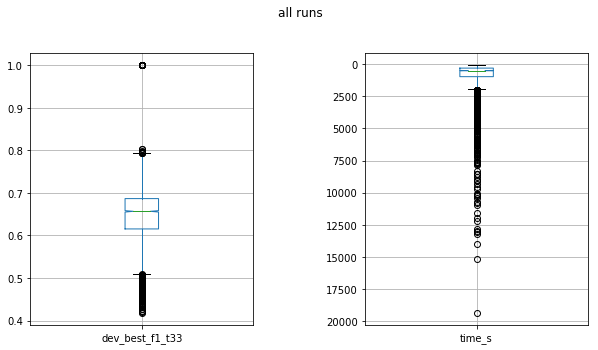

In [71]:
from matplotlib import rcParams
# final
#figsize = (4.5, 3)
# debug
figsize = (10, 5)


current_metrics = metrics



#rcParams['axes.titlepad'] = 20 
#rcParams['axes.titlepad'] = 20 
images = {}
bootstrap=10000
#rcParams.update({'figure.autolayout': True})

fig_merged, axs = plt.subplots(1, len(current_metrics), figsize=figsize)
for i, m in enumerate(current_metrics):
    res.boxplot(column=m, figsize=(figsize[i] / len(current_metrics), figsize[1]), ax=axs[i], bootstrap=bootstrap, notch=True)
    if m in metrics_inverted:
        axs[i].invert_yaxis()

#axs[0].invert_yaxis()
#axs[0].minorticks_on()
#axs[0].grid(which='minor', linestyle=':', linewidth='0.3', color='black')
#res.boxplot(column='test_pearson_r', figsize=(figsize[0] / 2, figsize[1]), ax=axs[1], bootstrap=bootstrap, notch=True)
#axs[1].minorticks_on()
#axs[1].grid(which='minor', linestyle=':', linewidth='0.3', color='black')
fig_merged.suptitle('all runs', y=1.01)
plt.subplots_adjust(wspace=0.5)
images['fig_merged'] = fig_merged

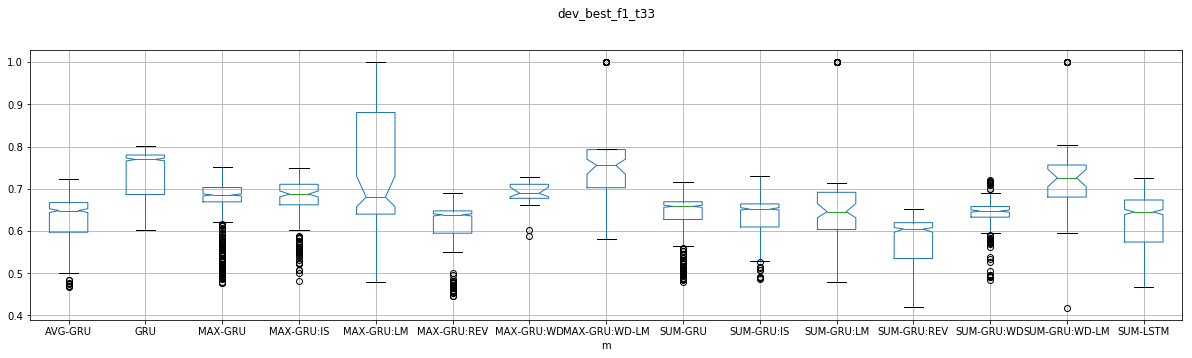

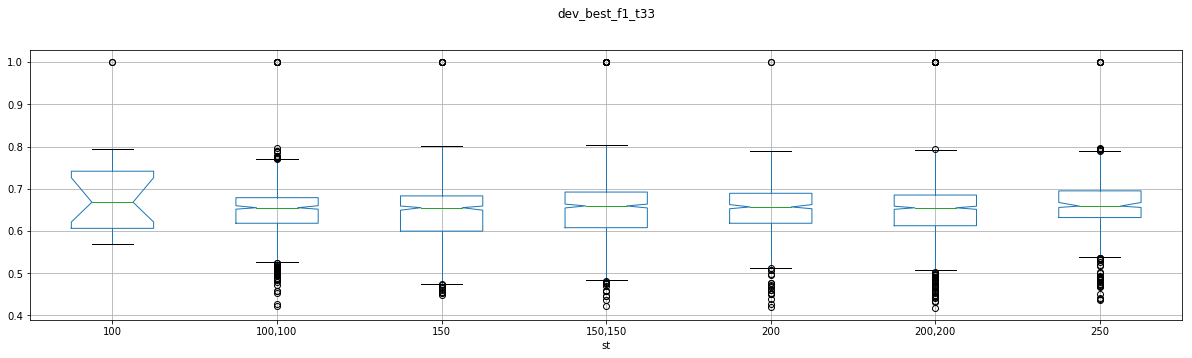

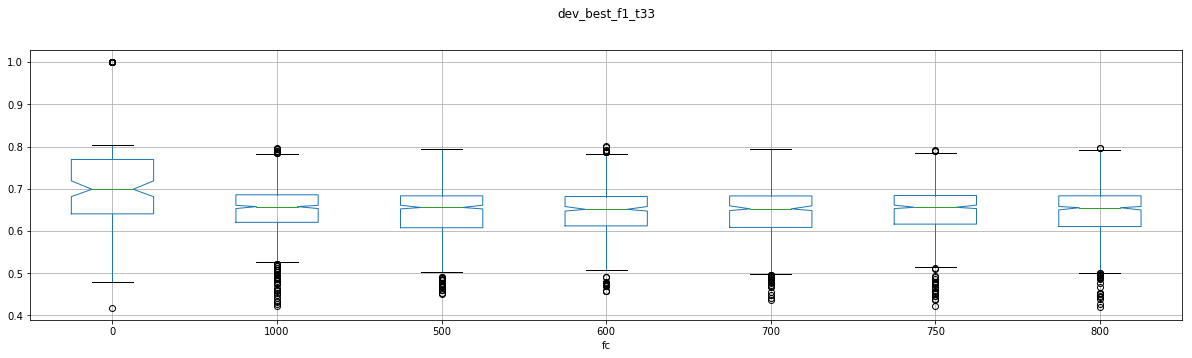

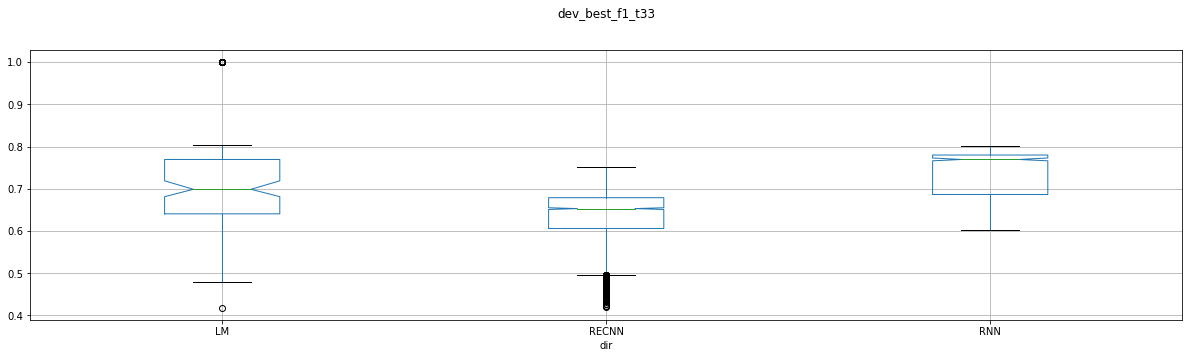

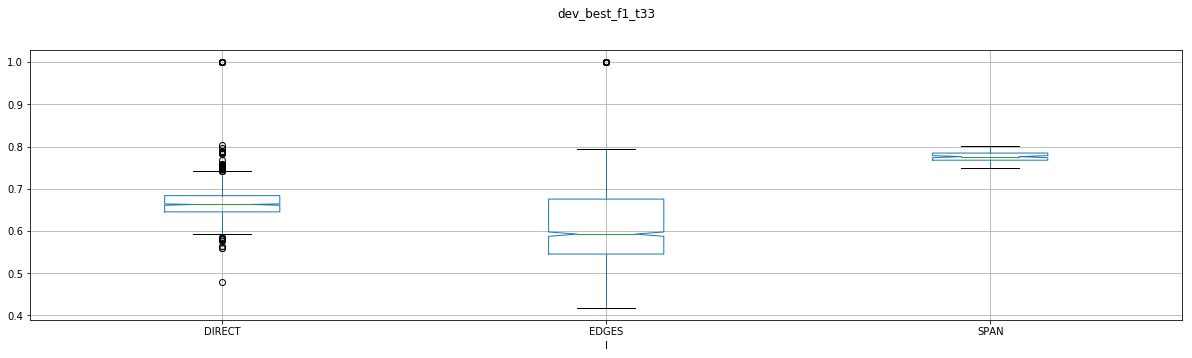

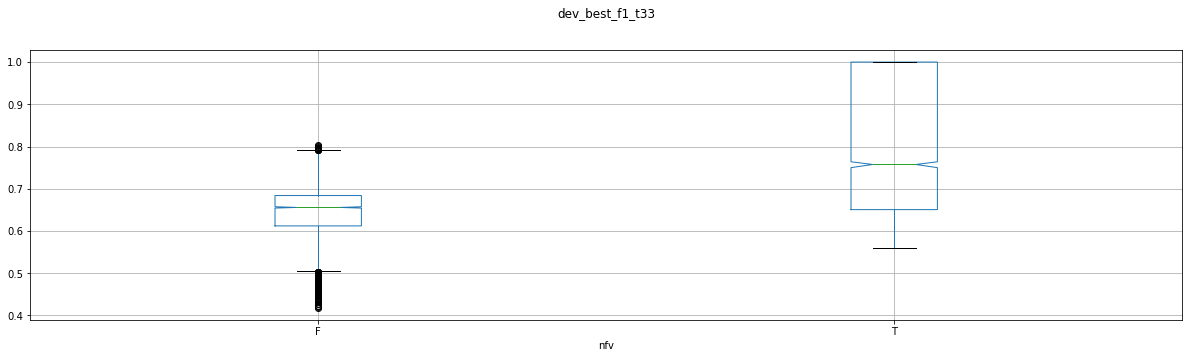

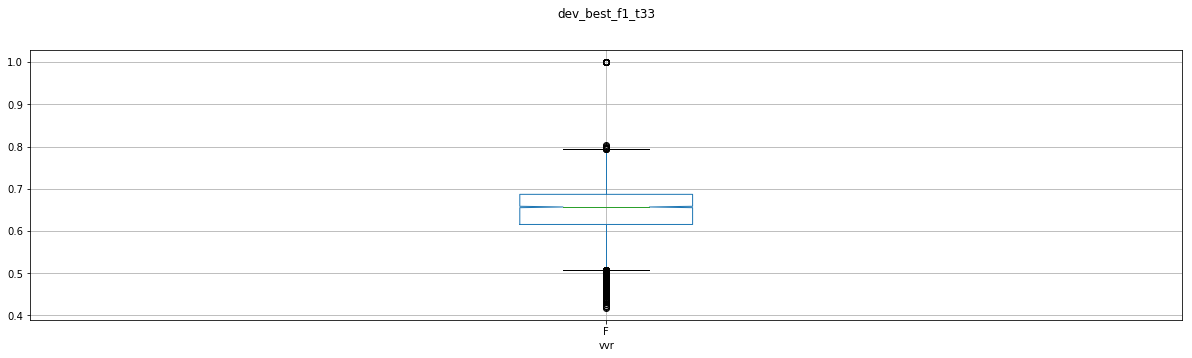

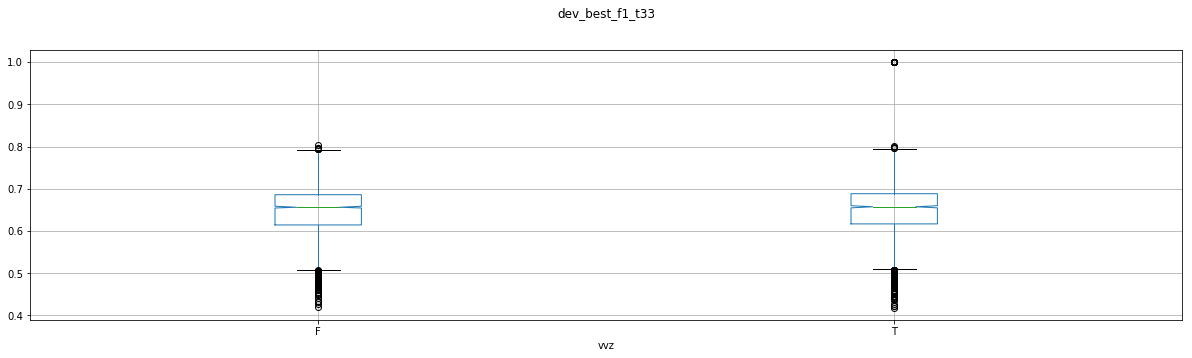

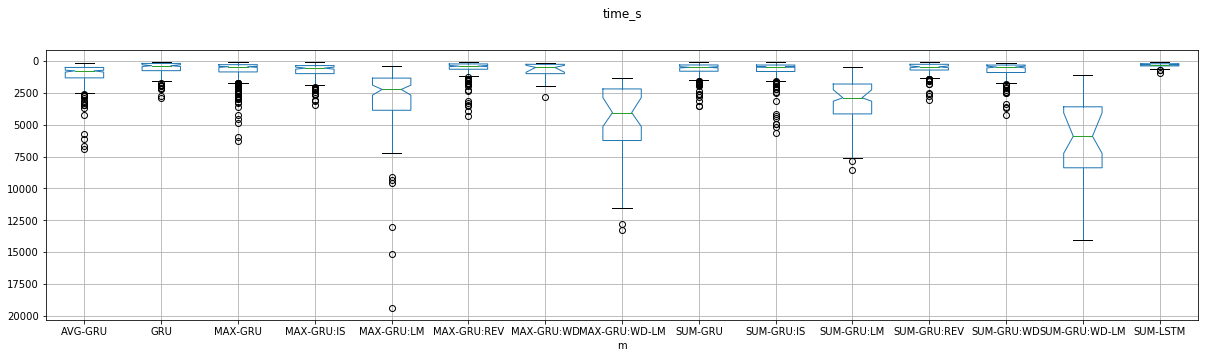

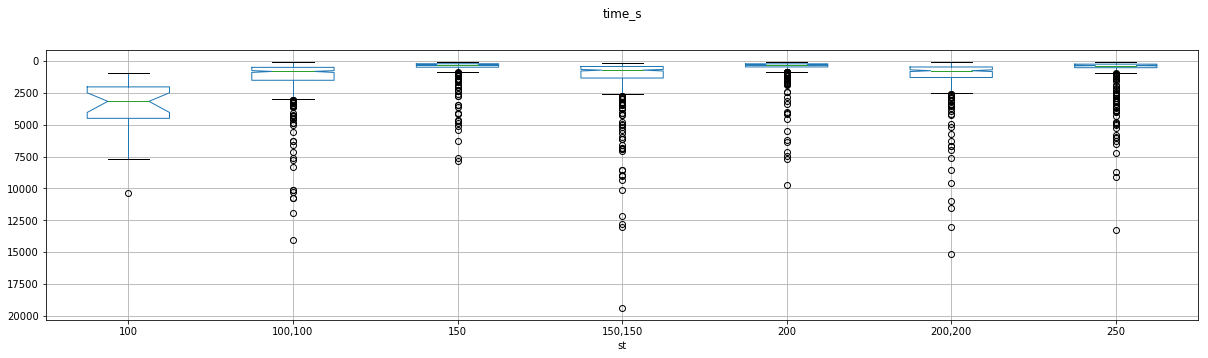

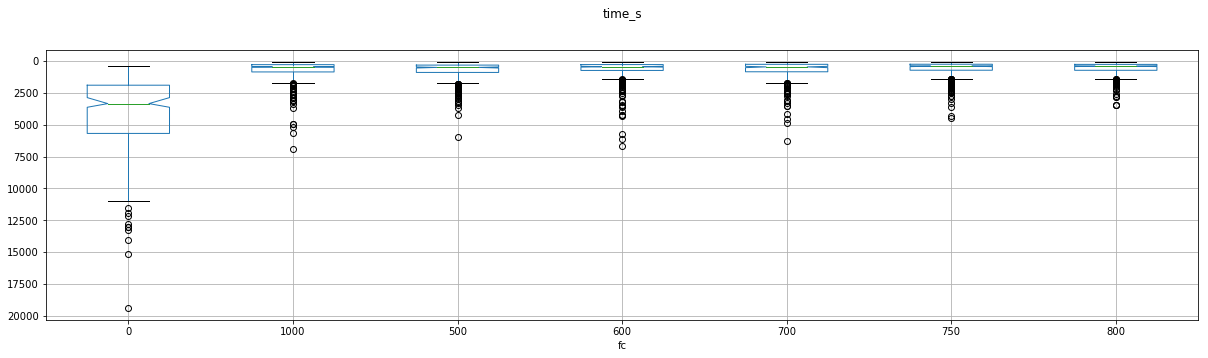

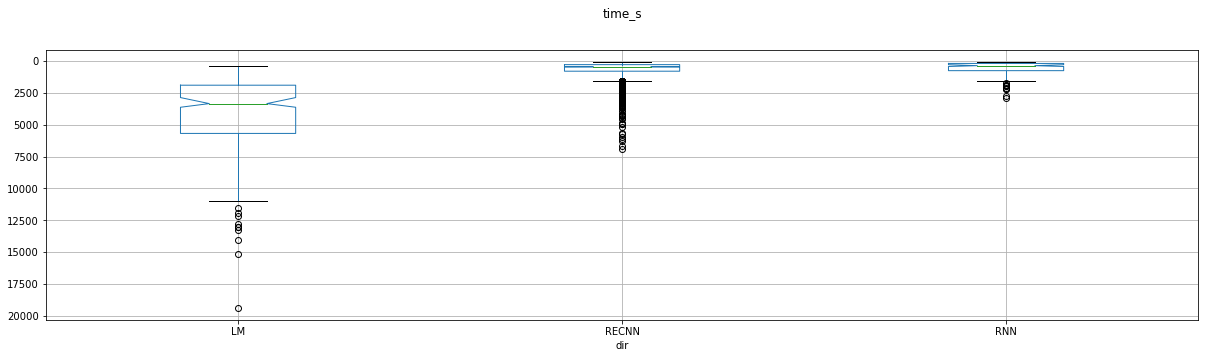

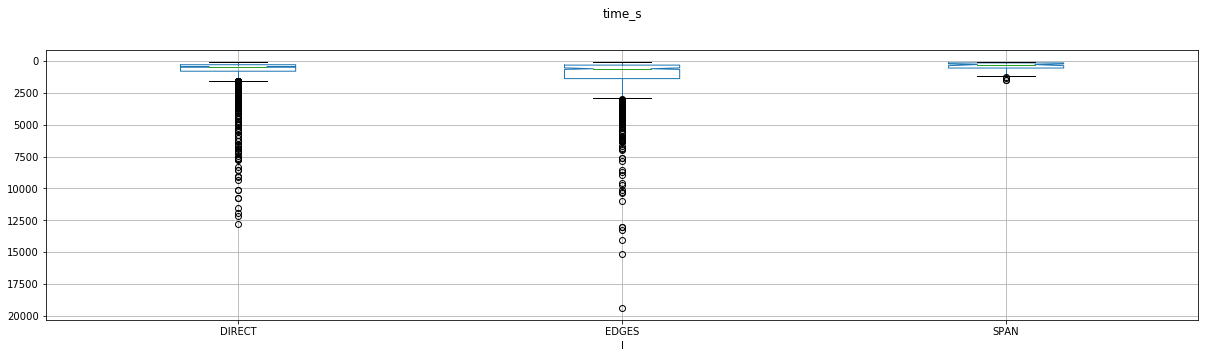

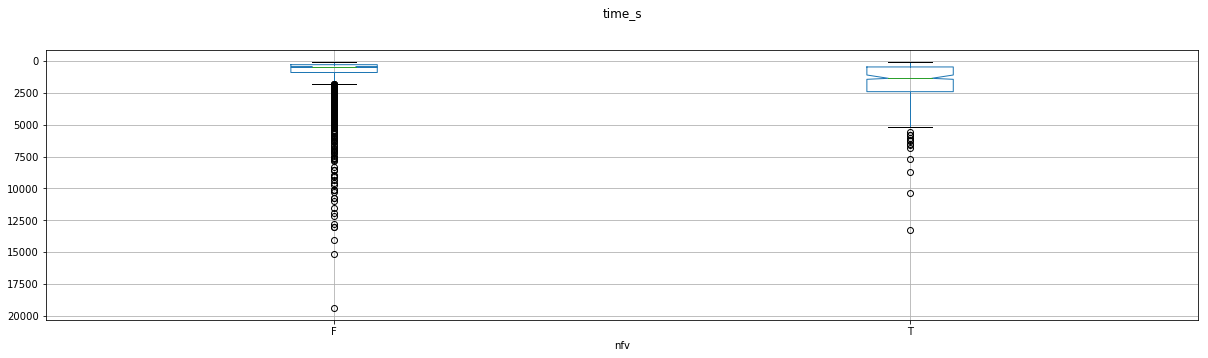

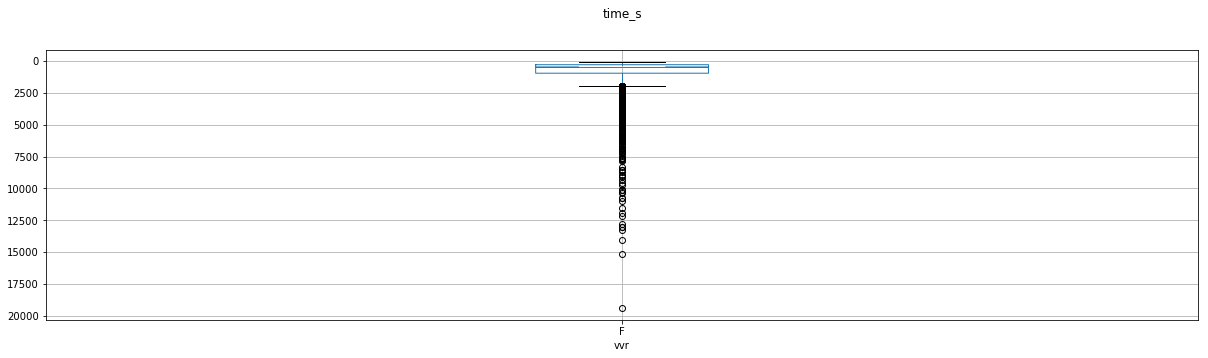

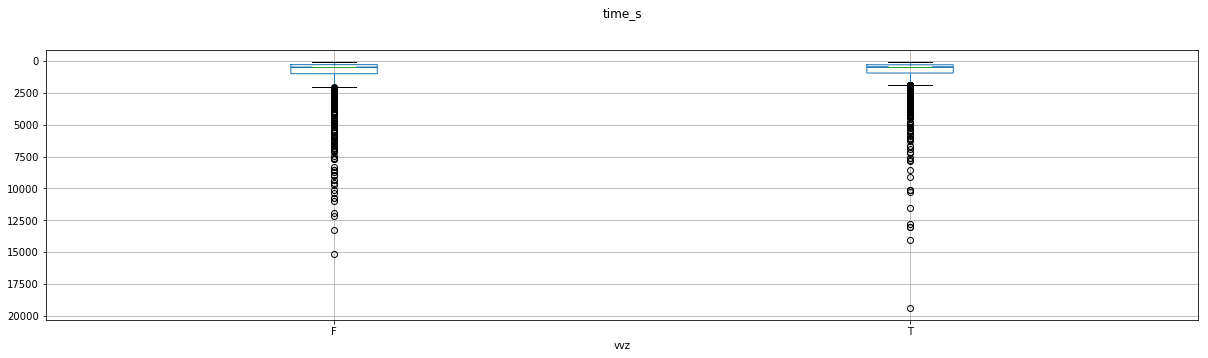

In [73]:
figsize = (20, 5)

y_title = 1.0
y_suptitle = 1.1

current_parameters = parameters[:2]
remaining_parameters = parameters[2:]
# use short versions

#levels = ['order aware', 'dependency available']
#other_level = {levels[0]: levels[1], levels[1]: levels[0]}
#other_parameter = {current_parameters[0]: current_parameters[1], current_parameters[1]:current_parameters[0]}

def param_long(param):
    #return ''.join([w[0].upper() for w in param.split()])
    return map_param_long.get(param, param)

def boxplot_sorted(df, by, column, **kwargs):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    return df2[meds.index].boxplot(rot=90, **kwargs)

current_values = get_current_values(df_all)

for m in current_metrics:
    for p in parameters:
        if len(current_values[p]) > 1:
            axs = res.boxplot(column=m, by=p, figsize=figsize, bootstrap=bootstrap, notch=True)
            if m in metrics_inverted:
                axs.invert_yaxis()
            #axs.minorticks_on()
            #axs.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
            plt.title(m, y=y_suptitle)
            fig_sep = axs.get_figure()
            fig_sep.suptitle('')
            images['fig_sep_'+m] = fig_sep




test_pearson_r
time_s


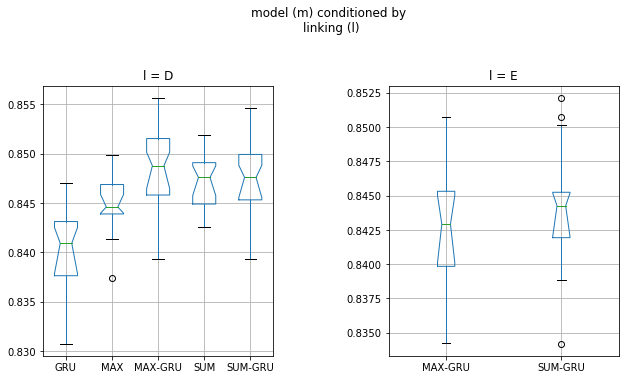

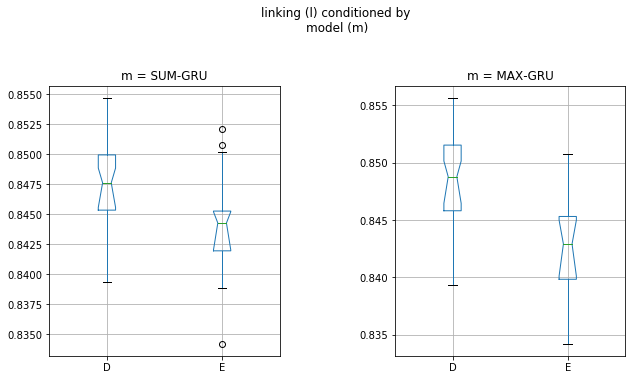

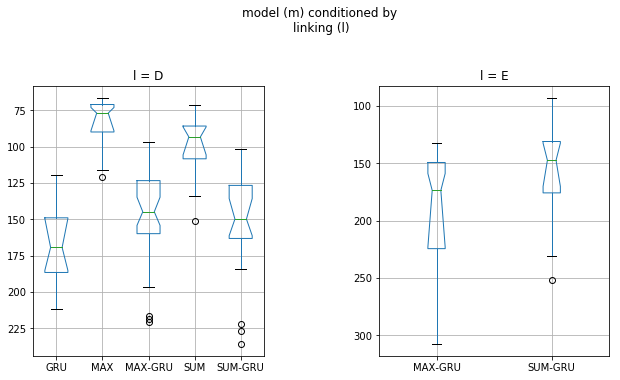

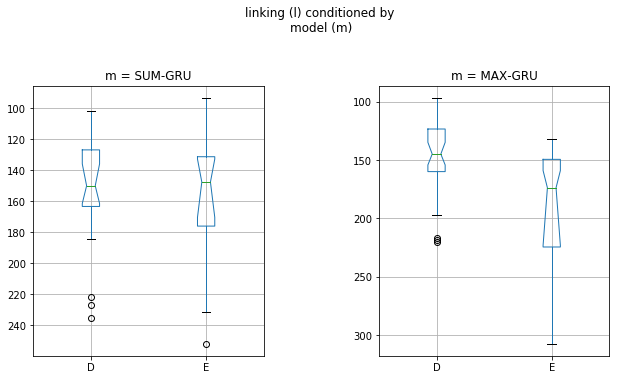

In [20]:
for m in current_metrics:
    print(m)
    for parameter in current_parameters:
        values = current_values[parameter]
        # collect values where other parameters has more then one values
        values_selected = []
        for i, v in enumerate(values):
            other_values = set(res.xs(v, level=parameter).index.values)
            if len(other_values) > 1:
                values_selected.append(v)
        
        fig_sep, axs_sep = plt.subplots(1,len(values_selected), figsize=figsize)
        for i, v in enumerate(values_selected):

            #res.xs(v, level=parameter).boxplot(column=['pearson'], by=[other_parameter[parameter]], ax=axs_sep[0], bootstrap=bootstrap, notch=True)
            #axs_sep[0].set_title('pearson', y=y_title)
            #axs_sep[0].set_xlabel('')
            #print(res.xs(v, level=parameter)[m].groupby([other_parameter[parameter]]).count())
            other_values = set(res.xs(v, level=parameter).index.values)
            if len(other_values) == 1:
                continue
            res.xs(v, level=parameter).boxplot(column=[m], by=[other_parameter[parameter]], ax=axs_sep[i], bootstrap=bootstrap, notch=True)
            axs_sep[i].set_title('%s = %s' % (parameter, v), y=y_title)
            axs_sep[i].set_xlabel('')
            if m in metrics_inverted:
                axs_sep[i].invert_yaxis()
        fig_sep.suptitle('%s (%s) conditioned by \n%s (%s)' % (param_long(other_parameter[parameter]), other_parameter[parameter], param_long(parameter), parameter), y=y_suptitle + 0.02)
        #fig_sep.suptitle('%s (%s) conditioned by \n%s (%s)' % (other_parameter[parameter], other_parameter[parameter], parameter, parameter), y=y_suptitle + 0.02)
        #plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
        plt.subplots_adjust(wspace=0.5)
        images['fig_sep_cond_%s' % other_parameter[parameter].split()[0]] = fig_sep


In [84]:
#import numpy
#from pandas import read_csv
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
#from math import sqrt
#import scipy.stats as st

def bootstrap_convidence(values, n_iterations=1000, alpha=0.95):
    #values = res.xs(('NO', 'NO'))['pearson']
    mean_b = np.mean(values)
    std_b = np.std(values)
    n_b_root = sqrt(len(values))
    # configure bootstrap
    #n_iterations = 10000
    n_size = int(len(values) * 0.10)
    # run bootstrap
    stats = list()
    for i in range(n_iterations):
        samples = resample(values, n_samples=n_size)
        t_i = (np.mean(samples) - mean_b) * n_b_root / np.std(samples)
        stats.append(t_i)
    # plot scores
    #pyplot.hist(stats)
    #pyplot.show()
    
    # confidence intervals
    #print(stats)
    #p_lower = ((1.0-alpha)/2.0) * 100
    p_lower = (alpha/2.) * 100
    #p = (alpha / 2.0) * 100
    lower = np.percentile(stats, p_lower)
    #lower = st.t._ppf(p_lower, n_iterations-1)
    #print('lower %.2f: %.3f' % (p_lower, lower))
    #p_upper = (alpha+((1.0-alpha)/2.0)) * 100
    p_upper = (1.-alpha/2.) * 100
    #p = (1.0 - alpha / 2.0) * 100
    upper = np.percentile(stats, p_upper)
    #upper = st.t._ppf(p_upper, n_iterations-1)
    #print('upper %.1f: %.3f' % (p_upper, upper))
    c_intv = [mean_b + lower * std_b / n_b_root, mean_b + upper * std_b / n_b_root]
    return c_intv

#def mean_confidence(values, alpha=0.95):
#    return st.t.interval(alpha, len(values)-1, loc=np.mean(values), scale=st.sem(values))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h


alpha = 0.5
for m in current_metrics:
    print('confidence intervalls for %s (%s):' % (m, ', '.join(current_parameters)))
    values = res[m]
    conf_simple = mean_confidence_interval(values, confidence=1-alpha)
    print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s naive' % ('ALL', 100 - alpha*100, conf_simple[1],conf_simple[2], conf_simple[2] - conf_simple[1], conf_simple[1] <= conf_simple[0] <= conf_simple[2]))
    c_boot = bootstrap_convidence(values, alpha=alpha)
    print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s' % ('ALL', 100 - alpha*100, c_boot[0],c_boot[1], c_boot[1] - c_boot[0], c_boot[0] <= conf_simple[0] <= c_boot[1]))
    #for setting in [('NO', 'NO'), ('NO', 'YES'), ('YES', 'NO'), ('YES', 'YES')]:
    for setting in sorted(set(res.index.values)):
        values = res.xs(setting)[m]
        conf_simple = mean_confidence_interval(values, confidence=1-alpha)
        print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s naive' % (str(setting), 100 - alpha*100, conf_simple[1],conf_simple[2], conf_simple[2] - conf_simple[1], conf_simple[1] <= conf_simple[0] <= conf_simple[2]))
        c_boot = bootstrap_convidence(values=values, alpha=alpha)
        print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s' % (str(setting), 100 - alpha*100, c_boot[0],c_boot[1], c_boot[1] - c_boot[0], c_boot[0] <= conf_simple[0] <= c_boot[1]))
print('finished')  


confidence intervalls for dev_best_f1_t33 (m, st):
ALL             50.0% confidence interval: 0.6504 and 0.6523 (0.0020) True naive
ALL             50.0% confidence interval: 0.6481 and 0.6543 (0.0062) True
('AVG-GRU', '100,100', '1000', 'RECNN', 'DIRECT', 'F', 'F', 'F') 50.0% confidence interval: 0.6504 and 0.6554 (0.0050) True naive


/home/arne/miniconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)
/home/arne/miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


('AVG-GRU', '100,100', '1000', 'RECNN', 'DIRECT', 'F', 'F', 'F') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '1000', 'RECNN', 'DIRECT', 'F', 'F', 'T') 50.0% confidence interval: 0.6408 and 0.6607 (0.0199) True naive
('AVG-GRU', '100,100', '1000', 'RECNN', 'DIRECT', 'F', 'F', 'T') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '1000', 'RECNN', 'EDGES', 'F', 'F', 'F') 50.0% confidence interval: 0.5463 and 0.5471 (0.0008) True naive
('AVG-GRU', '100,100', '1000', 'RECNN', 'EDGES', 'F', 'F', 'F') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '1000', 'RECNN', 'EDGES', 'F', 'F', 'T') 50.0% confidence interval: nan and nan (nan) False naive


/home/arne/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/arne/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


('AVG-GRU', '100,100', '1000', 'RECNN', 'EDGES', 'F', 'F', 'T') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '500', 'RECNN', 'DIRECT', 'F', 'F', 'F') 50.0% confidence interval: 0.6524 and 0.6587 (0.0064) True naive
('AVG-GRU', '100,100', '500', 'RECNN', 'DIRECT', 'F', 'F', 'F') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '500', 'RECNN', 'DIRECT', 'F', 'F', 'T') 50.0% confidence interval: 0.6630 and 0.6782 (0.0152) True naive
('AVG-GRU', '100,100', '500', 'RECNN', 'DIRECT', 'F', 'F', 'T') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '500', 'RECNN', 'EDGES', 'F', 'F', 'F') 50.0% confidence interval: 0.6204 and 0.6387 (0.0182) True naive
('AVG-GRU', '100,100', '500', 'RECNN', 'EDGES', 'F', 'F', 'F') 50.0% confidence interval: nan and nan (nan) False
('AVG-GRU', '100,100', '500', 'RECNN', 'EDGES', 'F', 'F', 'T') 50.0% confidence interval: 0.5327 and 0.5403 (0.0076) True naive
('AVG-GRU', '100,100', '500

KeyboardInterrupt: 

In [13]:
# NOT NECESSARY! use res.xs instead

#df_all_temp = df_all[current_parameters + current_metrics + [COLUMN_RUN, COLUMN_DFIDX]]
#df_all_temp = df_all_temp[df_all_temp[current_parameters[0]] == current_values[current_parameters[0]][0]]

# all settings seperated
pivot = {}
for m in current_metrics:
    #df_all_m[m] = df_all[current_parameters + [m] + [COLUMN_RUN, COLUMN_DFIDX]]
    pivot[m] = pd.pivot_table(res, values=m, index=[COLUMN_RUN, COLUMN_DFIDX], columns=current_parameters)
#pivot['pearson'] = pd.pivot_table(res_['pearson'], values='score_pearson', index=['crossfold_id', 'dev_file_index'], columns=['dependency available','order aware'])
#pivot['mse'] = pd.pivot_table(res_['mse'], values='score_mse', index=['crossfold_id', 'dev_file_index'], columns=['dependency available','order aware'])

# separated by order aware
#pivot_merged = {'pearson':{}, 'mse':{}}
pivot_merged = {}
for m in current_metrics:
    pivot_merged[m] = {} 
    for p in current_parameters:
        pivot_merged[m][p] = pd.pivot_table(res, values=m, index=[COLUMN_RUN, COLUMN_DFIDX] + [other_parameter[p]], columns=[p])
#pivot_merged['pearson']['order aware'] = pd.pivot_table(res_['pearson'], values='score_pearson', index=['crossfold_id', 'dev_file_index', 'dependency available'], columns=['order aware'])
#pivot_merged['mse']['order aware'] = pd.pivot_table(res_['mse'], values='score_mse', index=['crossfold_id', 'dev_file_index', 'dependency available'], columns=['order aware'])
## spereated by dependency available
##pivot_dep = {}
#pivot_merged['pearson']['dependency available'] = pd.pivot_table(res_['pearson'], values='score_pearson', index=['crossfold_id', 'dev_file_index', 'order aware'], columns=['dependency available'])
#pivot_merged['mse']['dependency available'] = pd.pivot_table(res_['mse'], values='score_mse', index=['crossfold_id', 'dev_file_index', 'order aware'], columns=['dependency available'])
##pivot['mse'] #['NO', 'NO'] - pivot_mse['NO', 'YES']
##pivot_['pearson']['dependency available']['NO']
#pivot['mse'][:10]

#pivot['dev_best_pearson_r']
#pivot_merged['dev_best_pearson_r']['m']
#df_all_temp
#df_all_temp[df_all_temp['l'] == 'E']

In [107]:
best_settings = {}
for m in metrics:
    best_settings[m] = df_all.sort_values(metrics[0], ascending=False).drop_duplicates(parameters).iloc[0]
best_settings[metrics[0]][parameters]

m      SUM-GRU:WD-LM
st           150,150
fc                 0
dir               LM
l             DIRECT
nfv                F
vvr                F
vvz                F
Name: 3101, dtype: object

In [86]:
p_threshold = 0.01
print('individual parameter change (">" indicates nbr of changed parameters); X marks significant change (p < %s)' % p_threshold)
parameter_settings = sorted(set(res.index.values
for m in current_metrics:
    print
    print(m)
    _res = []
    for i, s1 in enumerate(parameter_settings):
        for s2 in parameter_settings[i+1:]:
            nbr_equal_params = sum(map(lambda x: x[0] == x[1], zip(s1, s2)))
            nbr_changed_params = (len(current_parameters) - nbr_equal_params)
            tabs = ''.join(['>'] * nbr_changed_params)
            #%-15s %.1f
            #if s1 != s2:
            #dif = pivot[m][s2[0], s2[1]].mean() - pivot[m][s1[0], s1[1]].mean()
            dif = res.xs(s2)[m].mean() - res.xs(s1)[m].mean()
            per = (dif / res.xs(s1)[m].mean()) * 100
            #ttest = stats.ttest_ind(pivot[m][s1[0], s1[1]], pivot[m][s2[0], s2[1]], equal_var=False)
            ttest = stats.ttest_ind(res.xs(s1)[m], res.xs(s2)[m], equal_var=False)
            _res.append({'tabs': tabs, 'setting_a': str(s1), 'setting_b': str(s2), 't_statistic': ttest[0], 'p_value': ttest[1], 'dif': dif, 'dif_per': per, 'nbr_changed_params': nbr_changed_params})
            #_res.append('%s %-18s -> %-20s %10.4f   %.4f    dif=%8.4f' % (tabs, str(s1), str(s2), ttest[0], ttest[1], dif))
    #print('\n'.join(sorted(_res)))
    _res = sorted(_res, key=lambda x: abs(x['dif']), reverse=True)
    for r in _res:
        print('{tabs} {setting_a:18} -> {setting_b:18}\t{t_statistic:10.4f}   {p_value:.4f}    dif={dif:8.4f} {dif_per:5.2f}%'.format(**r) + ('\tX' if r['p_value'] < p_threshold else ''))
    

individual parameter change (">" indicates nbr of changed parameters); X marks significant change (p < 0.01)

dev_best_f1_t33


/home/arne/miniconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


KeyboardInterrupt: 

In [15]:
print('aggregated parameter change')
for m in current_metrics:
    print
    print(m)
    _res = []
    for parameter in current_parameters:
        param_values = current_values[parameter]
        if len(param_values) <= 1:
            continue
        data = []
        for v in param_values:
            values = numpy.sort(res.xs(v, level=parameter)[m].values)
            #values = numpy.sort(pivot_merged[m][parameter][v].values)
            mean = values.mean()
            #print(pivot_merged[m][parameter][v])
            data.append((v, mean, values))
        data = sorted(data, key=lambda x: x[0])#, reverse=True)
        #mean_NO = pivot_merged[m][parameter]['NO'].mean()
        #mean_YES = pivot_merged[m][parameter]['YES'].mean()
        mean_a = data[0]
        mean_b = data[1]
        for i, data_a in enumerate(data):
            for data_b in data[i+1:]:
                #mean_dif = mean_YES - mean_NO
                #mean_dif = means[1][0] - means[0][0]
                dif = data_b[1] - data_a[1]
                #ttest = stats.ttest_ind(pivot_merged[measure][parameter]['NO'], pivot_merged[m][parameter]['YES'], equal_var=False)
                ttest = stats.ttest_ind(data_a[2], data_b[2], equal_var=False)
                #print('(merged) %-20s    %-10s  %10.4f   %.4f  (%.4f -> %.4f = %8.4f)' % (parameter, m, ttest[0], ttest[1], mean_NO, mean_YES, mean_dif))
                #print('(merged) %-5s %-10s -> %-10s %10.4f   %.4f  (%8.4f -> %8.4f = %8.4f)' % (parameter, data_a[0], data_b[0], ttest[0], ttest[1], data_a[1], data_b[1], mean_dif))
                _res.append({'parameter':parameter, 'setting_a': data_a[0], 'setting_b': data_b[0], 't_statistic': ttest[0], 'p_value': ttest[1], 'dif': dif, 'dif_per': (dif / data_a[1]) * 100})
                #merged = 'order aware'
                #mean_dif = pivot_merged[measure][parameter]['YES'].mean() - pivot_merged[measure][parameter]['NO'].mean()
                #ttest = stats.ttest_ind(pivot_merged[measure][parameter]['NO'], pivot_merged[measure][parameter]['YES'], equal_var=False)
                #print('(merged) %-20s    %-10s  %10.4f   %.4f  %8.4f' % (parameter, measure, ttest[0], ttest[1], mean_dif))
    _res = sorted(_res, key=lambda x: abs(x['dif']), reverse=True)
    for r in _res:
        print('{parameter}\t{setting_a:18} -> {setting_b:18}\t{t_statistic:10.4f}   {p_value:.4f}    dif={dif:8.4f} {dif_per:5.2f}%'.format(**r) + ('\tX' if r['p_value'] < p_threshold else ''))

aggregated parameter change

test_pearson_r
m	GRU                -> SUM               	   -7.1515   0.0000    dif=  0.0071  0.85%	X
m	GRU                -> SUM-GRU           	   -5.5192   0.0000    dif=  0.0057  0.68%	X
m	GRU                -> MAX-GRU           	   -4.5825   0.0000    dif=  0.0051  0.61%	X
m	GRU                -> MAX               	   -4.7452   0.0000    dif=  0.0048  0.57%	X
m	MAX                -> SUM               	   -3.2687   0.0020    dif=  0.0024  0.28%	X
l	D                  -> E                 	    3.2428   0.0016    dif= -0.0023 -0.27%	X
m	MAX-GRU            -> SUM               	   -2.2740   0.0259    dif=  0.0020  0.24%
m	SUM                -> SUM-GRU           	    1.8211   0.0729    dif= -0.0014 -0.17%
m	MAX                -> SUM-GRU           	   -1.2411   0.2188    dif=  0.0010  0.12%
m	MAX-GRU            -> SUM-GRU           	   -0.6405   0.5234    dif=  0.0006  0.07%
m	MAX                -> MAX-GRU           	   -0.4238   0.6729    dif=  0.0004  0.04